In [ ]:
# !pip install -r requirements.txt --extra-index-url https://pypi.org/simple
#!module load libspatialindex

In [ ]:
print("H33ello, Wokjkrld!")

H33ello, Wokjkrld!


In [80]:
%reload_ext autoreload

In [1]:
# import torch
# from torchgeo.samplers import GeoSampler
# from torchgeo.datasets.utils import BoundingBox
# from typing import Iterator, Union
# from shapely.geometry import Point
# from pyproj import Transformer

import geopandas as gpd
# from torchgeo.datasets import RasterDataset
# from typing import Any, ClassVar, cast
# from torch import Tensor
# import re
# import matplotlib.pyplot as plt
# import numpy as np
# import rasterio
# import pandas as pd
# Example usage
import sys
sys.path.append("./notebooks")  # Adjust the path if model_evaluation.py is elsewhere
from utils.model_evaluation import evaluate_fusion_cnn

%load_ext autoreload
%autoreload 2

/home/alexisb1/species-dist/ENV/lib/python3.11/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [1]:
!squeue -u $USER

          JOBID     USER      ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 
        5244784 alexisb1 def-dgravel_    interactive   R    1:31:25     1    6        N/A    128G fc11020 (None) 


In [2]:
from shapely.wkt import loads as wkt_loads
processed_species_original_locations = gpd.read_file("data/saved_df/processed_species_original_locations_point_data.csv")
processed_species_original_locations['geometry'] = processed_species_original_locations['geometry'].apply(wkt_loads)
processed_species_original_locations = gpd.GeoDataFrame(processed_species_original_locations, geometry='geometry', crs="EPSG:6624")
processed_species_original_locations = processed_species_original_locations.to_crs(epsg=4326)

In [3]:
from models.multi_species_fusion_cnn import create_species_configs
def calculate_species_presence_ratio(processed_species_original_locations, species_codes):
    """
    Calculate the ratio of presence for each species in the species_list column.

    Args:
        processed_species_original_locations (GeoDataFrame): DataFrame with a 'species_list' column.
        species_codes (list): List of species codes to check.

    Returns:
        dict: {species_code: presence_ratio}
    """
    total_rows = len(processed_species_original_locations)
    ratios = {}
    for species in species_codes:
        count = processed_species_original_locations['species_list'].apply(lambda x: species in x).sum()
        ratios[species] = count / total_rows
    return ratios


#convert the species_list column which is a list into a list. Now its interpreted as a full string
processed_species_original_locations['species_list'] = processed_species_original_locations['species_list'].apply(lambda x: eval(x) if isinstance(x, str) else x)
#extract all species code from species_list column into a flat list this column is a list of strings
all_species_codes = []
for species_list in processed_species_original_locations['species_list']:
    for species in species_list:
        if species not in all_species_codes:
            all_species_codes.append(species)
species_presence_ratios = calculate_species_presence_ratio(processed_species_original_locations, all_species_codes)

#sort species by presence ratio
sorted_species = sorted(species_presence_ratios.items(), key=lambda x: x[1], reverse=True)

#only keep species with presence ratio > 0.01
filtered_sorted_species = [item for item in sorted_species if item[1] > 0.05]

species_presence_ratios = calculate_species_presence_ratio(processed_species_original_locations, all_species_codes)
#sort species by presence ratio
sorted_species = sorted(species_presence_ratios.items(), key=lambda x: x[1], reverse=True)

#only keep species with presence ratio > 0.01
filtered_sorted_species = [item for item in sorted_species if item[1] > 0.05]

filtered_species_codes = [item[0] for item in filtered_sorted_species]

selected_species = filtered_sorted_species[0:5] + filtered_sorted_species[20:25] + filtered_sorted_species[50:55] + filtered_sorted_species[90:95]
#selected_species = filtered_sorted_species[90:100]
species_names = [item[0] for item in selected_species]
prevalences = [item[1] for item in selected_species]

species_configs = create_species_configs(species_names, prevalences, loss_type="asymmetric", variant='balanced')

### Single species model

In [ ]:

# NEW BASE CONFIG - Apply these changes to ALL following configs
base_config = {
        'use_focal_loss': False,        # Keep OFF
        'use_asymmetric_loss': False,   # Keep OFF
        'use_deeper_cnn': True,
        'print_every': 1,
        'batch_size': 256,
        'hidden_dims': [256, 128, 64],  # CHANGED from [512, 256, 128]
        'learning_rate': 1e-3,          # CHANGED from 1e-3
        'optimizer': 'adamw',
        'weight_decay': 1e-2,           # UNCOMMENTED
        'dropout': 0.5,
        'use_scheduler': True,
        'add_point_infos': True,
        'resize_ratio': 0.2,
        'use_satelite': False,
        'use_pretrained_climate_cnn': False,
        'epochs': 20,  # Reduce from 50
        'early_stopping_patience': 3,  # Reduce from 10
        'early_stopping_warmup': 2,   # Reduce from 5
        'early_stopping_delta': 0.01, # Increase from 0.001 for stricter improvement
        'early_stopping_metric': 'f1', # F1 often stabilizes faster than loss
}

    # {
    #     'name': 'Tuned3 Focal Loss + sentinel2',
    #     'use_attention': False,
    #     'use_focal_loss': True,
    #     'focal_alpha': 1,
    #     'focal_gamma': 1.0,
    #     'use_spatial_features': False,
    #     #'spatial_feature_dim': 32,
    #     'use_deeper_cnn': False,
    #     'print_every': 1,
    #     'batch_size': 256,
    #     'hidden_dims': [128, 64],
    #     'learning_rate': 1e-3,
    #     'optimizer': 'adamw',
    #     #'weight_decay': 1e-3,
    #     'dropout': 0.5,
    #     'use_scheduler': True,
    #     'add_point_infos': True,
    #     'resize_ratio': 0.2,
    #     'use_satelite': False
    # },
configs = [
    {
        'name': 'WDecay 1e-2 Dropout 0.1',
        'use_attention': True,
        'use_pretrained_climate_cnn': True,
        'use_spp': False,
        'use_satelite': True,
        'dropout': 0.1,
        **base_config  # This injects all the base settings
    },
        {
        'name': 'WDecay 1e-2 Dropout 0.25',
        'use_attention': True,
        'use_pretrained_climate_cnn': True,
        'use_spp': False,
        'use_satelite': True,
        'dropout': 0.25,
        **base_config  # This injects all the base settings
    },
        {
        'name': 'WDecay 1e-2 Dropout 0.5',
        'use_attention': True,
        'use_pretrained_climate_cnn': True,
        'use_spp': False,
        'use_satelite': True,
        'dropout': 0.5,
        **base_config  # This injects all the base settings
    },
    


]


#cell_sizes = [0.5, 1, 1.5]
cell_sizes = [1]
target_species_arr = ['ERP', 'SAB','LEG']  # Add more species

results = evaluate_fusion_cnn(cell_sizes, target_species_arr, processed_species_original_locations, configs)
print(results)

Starting evaluation...

Processing species: ERP
Got 34 feature importances for ERP

Cell size: 1 degrees
Total points: 24732 | Train: 20466 | Val: 4266
Processed species locations shape in dataset: (20466, 69)
Loading shape from: ../scratch/data/npy_data/pred100_patches.npy
Loaded with shape: [24732, 67, 100, 100]
Extracted point infos shape: (20466, 34)
Extracted coordinates shape: torch.Size([20466, 2])
Dataset size: 20466, Positives: 3820.0, Positive ratio: 0.1867
Processed species locations shape in dataset: (4266, 69)
Loading shape from: ../scratch/data/npy_data/pred100_patches.npy
Loaded with shape: [24732, 67, 100, 100]
Extracted point infos shape: (4266, 34)
Extracted coordinates shape: torch.Size([4266, 2])
Dataset size: 4266, Positives: 576.0, Positive ratio: 0.1350

Testing config: WDecay 1e-2 Dropout 0.1
Computed pos_weight: 4.36
Using device: cuda
Building branch 0 for source 'pred_100' with shape (67, 20, 20)
Building branch 1 for source 'point_infos' with shape (34,)
Tab


Epoch [1/20]:
  Train - Acc: 0.6331, Loss: 0.8632, F1: 0.4727, AUC: 0.4520
  Val   - Acc: 0.6800, Loss: 0.8448, F1: 0.4573, AUC: 0.5766
  LR: 0.001000
  Best f1: 0.4573 (epoch 1)
  ✓ New best f1: 0.4573
  Early stopping: 0/3



Epoch [2/20]:
  Train - Acc: 0.7907, Loss: 0.6195, F1: 0.6228, AUC: 0.5865
  Val   - Acc: 0.7935, Loss: 0.5527, F1: 0.5571, AUC: 0.6166
  LR: 0.001000
  Best f1: 0.5571 (epoch 2)
  ✓ New best f1: 0.5571
  Early stopping: 0/3



Epoch [3/20]:
  Train - Acc: 0.8080, Loss: 0.5810, F1: 0.6429, AUC: 0.6281
  Val   - Acc: 0.6746, Loss: 0.6784, F1: 0.4527, AUC: 0.6312
  LR: 0.001000
  Best f1: 0.5571 (epoch 2)
  ✗ No improvement for 1 epochs
  Early stopping: 1/3



Epoch [4/20]:
  Train - Acc: 0.8155, Loss: 0.5537, F1: 0.6526, AUC: 0.6518
  Val   - Acc: 0.8392, Loss: 0.4684, F1: 0.5955, AUC: 0.6366
  LR: 0.001000
  Best f1: 0.5955 (epoch 4)
  ✓ New best f1: 0.5955
  Early stopping: 0/3



Epoch [5/20]:
  Train - Acc: 0.8215, Loss: 0.5380, F1: 0.6607, AUC: 0.6784
  Val   - Acc: 0.8643, Loss: 0.4516, F1: 0.6342, AUC: 0.6711
  LR: 0.001000
  Best f1: 0.6342 (epoch 5)
  ✓ New best f1: 0.6342
  Early stopping: 0/3



Epoch [6/20]:
  Train - Acc: 0.8275, Loss: 0.5325, F1: 0.6659, AUC: 0.6716
  Val   - Acc: 0.7586, Loss: 0.5362, F1: 0.5182, AUC: 0.6571
  LR: 0.001000
  Best f1: 0.6342 (epoch 5)
  ✗ No improvement for 1 epochs
  Early stopping: 1/3



Epoch [7/20]:
  Train - Acc: 0.8278, Loss: 0.5303, F1: 0.6678, AUC: 0.6759
  Val   - Acc: 0.8582, Loss: 0.4715, F1: 0.6149, AUC: 0.6610
  LR: 0.001000
  Best f1: 0.6342 (epoch 5)
  ✗ No improvement for 2 epochs
  Early stopping: 2/3



Epoch [8/20]:
  Train - Acc: 0.8274, Loss: 0.5201, F1: 0.6698, AUC: 0.6834
  Val   - Acc: 0.8959, Loss: 0.6075, F1: 0.6231, AUC: 0.6371
  LR: 0.000200
  Best f1: 0.6342 (epoch 5)
  ✗ No improvement for 3 epochs
  Early stopping: 3/3

🚨 Early stopping triggered after 8 epochs!
   Best performance at epoch 5:
   accuracy: 0.8643
   f1: 0.6342
   precision: 0.4985
   recall: 0.8715
   pr_auc: 0.6711
   specificity: 0.7639
   loss: 0.4516

✅ Loaded best model from epoch 5
Saved results to results.csv
Processed species locations shape in dataset: (20466, 69)
Loading shape from: ../scratch/data/npy_data/pred100_patches.npy
Loaded with shape: [24732, 67, 100, 100]
Extracted point infos shape: (20466, 34)
Extracted coordinates shape: torch.Size([20466, 2])
Dataset size: 20466, Positives: 3820.0, Positive ratio: 0.1867
Processed species locations shape in dataset: (4266, 69)
Loading shape from: ../scratch/data/npy_data/pred100_patches.npy
Loaded with shape: [24732, 67, 100, 100]
Extracted poin


Epoch [1/20]:
  Train - Acc: 0.6608, Loss: 0.8276, F1: 0.4993, AUC: 0.4648
  Val   - Acc: 0.8467, Loss: 0.6311, F1: 0.6007, AUC: 0.5500
  LR: 0.001000
  Best f1: 0.6007 (epoch 1)
  ✓ New best f1: 0.6007
  Early stopping: 0/3


In [18]:
import pandas as pd
#read from csv
results_df = pd.read_csv("results.csv")

In [19]:
results_df

,species,cell_size,config_name,train_positive_ratio,val_positive_ratio,val_accuracy,val_f1,val_precision,val_recall,val_pr_auc,val_specificity,val_loss
0,"['RES_S', 'SAB', 'DIS', 'PLS', 'CON', 'FEU_S',...",0.5,Independant Heads with init,7.672668,7.666331,0.663256,0.585823,0.501087,0.885912,0.607873,0.488285,1.016945
1,"['RES_S', 'SAB', 'DIS', 'PLS', 'CON', 'FEU_S',...",0.5,Common Heads + Species specific,7.672668,7.666331,0.726946,0.600607,0.556493,0.765256,0.634266,0.724672,0.646260
2,"['RES_S', 'SAB', 'DIS', 'PLS', 'CON', 'FEU_S',...",0.5,SimpleMultiInputCNNv2WithMixtureExperts init_v2,6.202205,6.166129,0.790544,0.809161,0.826278,0.797704,0.870980,0.760293,0.397807
3,"['RES_S', 'SAB', 'DIS', 'PLS', 'CON', 'FEU_S',...",0.5,Common Heads + Species specific,6.202205,6.166129,0.778266,0.805015,0.816645,0.804626,0.867592,0.743108,0.353560
4,"['RES_S', 'SAB', 'DIS', 'PLS', 'CON', 'FEU_S',...",0.5,SimpleMultiInputCNNv2WithMixtureExperts + use_...,7.672668,7.666331,0.777792,0.637141,0.590785,0.763556,0.665372,0.775095,0.678672
5,"['RES_S', 'SAB', 'DIS', 'PLS', 'CON', 'FEU_S',...",0.5,SimpleMultiInputCNNv2WithMixtureExperts + froz...,7.672668,7.666331,0.776966,0.636069,0.590658,0.758758,0.664703,0.772923,0.693255
6,"['RES_S', 'SAB', 'DIS', 'PLS', 'CON', 'FEU_S',...",0.5,SimpleMultiInputCNNv2WithSpeciesSpecificClimate,7.672668,7.666331,0.732067,0.614833,0.565051,0.790080,0.640070,0.707681,0.619565
7,"['RES_S', 'SAB', 'DIS', 'PLS', 'CON', 'FEU_S',...",0.5,SimpleMultiInputCNNv2WithMixtureExperts + froz...,7.672668,7.666331,0.760081,0.631175,0.582855,0.782646,0.667758,0.752501,0.635579
8,"['RES_S', 'SAB', 'DIS', 'PLS', 'CON', 'FEU_S',...",0.5,SimpleMultiInputCNNv2WithMixtureExperts + froz...,7.672668,7.666331,0.765766,0.633886,0.587342,0.779568,0.672315,0.763185,0.618969


In [5]:
#group results by config_name
numeric_cols = results_df.select_dtypes(include='number').columns
grouped_results = results_df.groupby('config_name')[numeric_cols].mean().reset_index()
grouped_results.sort_values(by='val_f1', ascending=False)

,config_name,cell_size,train_positive_ratio,val_positive_ratio,val_accuracy,val_f1,val_precision,val_recall,val_pr_auc,val_specificity,val_loss
5,weight decay :1e-3 dropout 0.1,1.0,0.271695,0.233943,0.852555,0.703532,0.615211,0.832184,0.770266,0.696671,0.454763
3,Weigh decay: 1e-4,1.0,0.271695,0.233943,0.859705,0.701628,0.631987,0.795325,0.765018,0.715307,0.470156
1,Weigh decay: 1e-2,1.0,0.271695,0.233943,0.858415,0.698738,0.637586,0.789471,0.776478,0.724098,0.453872
6,weight decay :1e-3 dropout 0.25,1.0,0.271695,0.233943,0.851500,0.693365,0.630859,0.814965,0.771335,0.716010,0.462359
4,Weigh decay: 1e-5,1.0,0.271695,0.233943,0.843647,0.692189,0.597994,0.853108,0.776817,0.684482,0.446763
0,Weigh decay: 0,1.0,0.271695,0.233943,0.845523,0.690039,0.607373,0.835739,0.769872,0.696203,0.457383
2,Weigh decay: 1e-3,1.0,0.271695,0.233943,0.843179,0.689433,0.599717,0.841725,0.777627,0.689873,0.444886
7,weight decay :1e-3 dropout 0.5,1.0,0.271695,0.233943,0.816925,0.675294,0.548738,0.879294,0.766963,0.631739,0.488588


In [ ]:
# group by config_name and get mean of all numeric metrics
numeric_cols = results_df.select_dtypes(include='number').columns
grouped_results = results_df.groupby('config_name')[numeric_cols].mean().reset_index()
grouped_results

,config_name,cell_size,train_positive_ratio,val_positive_ratio,val_accuracy,val_f1,val_precision,val_recall,val_pr_auc,val_specificity,val_loss,train_accuracy,train_f1,train_precision,train_recall,train_pr_auc,train_specificity,train_loss
0,Tuned3 Focal Loss,0.843750,0.353677,0.347486,0.820478,0.773239,0.693772,0.876619,0.843554,0.558413,0.285711,0.822424,0.785405,0.691701,0.910305,0.836027,0.774421,0.281390
1,Tuned3 Focal Loss + pretrained climate cnn,0.839286,0.353849,0.346699,0.827659,0.778039,0.714645,0.858260,0.849149,0.579304,0.289746,0.828170,0.790843,0.697898,0.913315,0.844788,0.781598,0.274497
2,Tuned3 Focal Loss + sentinel2,0.833333,0.354078,0.345649,0.817887,0.778752,0.681631,0.916391,0.870414,0.529284,0.268958,0.842875,0.804496,0.719057,0.913020,0.867443,0.804416,0.258590
3,Tuned3 Focal Loss + sentinel2 + pretrained cli...,0.809524,0.354071,0.345685,0.826773,0.783148,0.694082,0.903867,0.870537,0.546597,0.267547,0.840774,0.803029,0.714410,0.916764,0.867716,0.799098,0.257705


In [4]:
from shapely.wkt import loads as wkt_loads
processed_species_original_locations = gpd.read_file("data/saved_df/processed_species_original_locations_point_data.csv")
processed_species_original_locations['geometry'] = processed_species_original_locations['geometry'].apply(wkt_loads)
processed_species_original_locations = gpd.GeoDataFrame(processed_species_original_locations, geometry='geometry', crs="EPSG:6624")
processed_species_original_locations = processed_species_original_locations.to_crs(epsg=4326)
processed_species_original_locations

,geometry,species_list,alluvion,annual_precipitation_amount,annual_range_of_air_temperature,barren,bulk_density,clay,combined_mask,coniferous,...,temperate_shrub,temperature_seasonality,till,tourbiere_boisee,tourbiere_indifferenciee,tourbiere_minerotrophe,tourbiere_ombrotrophe,urban,water,wetland
0,POINT (-78.18415 46.4555),"['ARN', 'AUR', 'BOP', 'CHH', 'COG', 'CON', 'DR...",0.0,0.43732795119285583,0.863043487071991,0.0,0.800000011920929,0.4047151207923889,1.0,0.8799999952316284,...,0.0,0.8279594779014587,0.9900686740875244,0.0,0.0,0.35949796438217163,0.0,0.0,0.0,0.0
1,POINT (-78.1816 46.45517),"['APA', 'ARN', 'ASM', 'AUR', 'BAT', 'BOP', 'CH...",0.0,0.43853235244750977,0.863043487071991,0.0,0.800000011920929,0.4047151207923889,1.0,0.7978150248527527,...,0.0,0.8270249366760254,0.7266126871109009,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,POINT (-78.17968 46.45499),"['ARN', 'ASM', 'AUR', 'BOP', 'CAX', 'CLB', 'CO...",0.0,0.43853235244750977,0.863043487071991,0.0,0.800000011920929,0.4047151207923889,1.0,0.7799999713897705,...,0.0,0.8270249366760254,0.9181524515151978,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,POINT (-78.17597 46.45457),"['ARN', 'ASM', 'BOP', 'CHH', 'CLB', 'COC', 'CO...",0.0,0.4386861324310303,0.863043487071991,0.0,0.800000011920929,0.4047151207923889,1.0,0.25983312726020813,...,0.0,0.8268796801567078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,POINT (-78.17846 46.45485),"['ARN', 'ASM', 'BOP', 'CLB', 'COC', 'DIE', 'DR...",0.0,0.43853235244750977,0.863043487071991,0.0,0.800000011920929,0.4047151207923889,1.0,0.4599464237689972,...,0.0,0.8270249366760254,0.13555632531642914,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24727,POINT (-70.66489 45.40489),"['AME', 'ARN', 'ASA', 'BAT', 'BOJ', 'BOP', 'CA...",0.0,0.5413368940353394,0.821739137172699,0.0,0.7037037014961243,0.19842828810214996,1.0,0.03999999910593033,...,0.0,0.7742990851402283,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24728,POINT (-70.66828 45.40126),"['ACP', 'ARN', 'ASA', 'BOJ', 'BOP', 'CAX', 'CI...",0.0,0.5234942436218262,0.8249654173851013,0.0,0.682436466217041,0.18714705109596252,1.0,0.0,...,0.0,0.7770152688026428,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24729,POINT (-70.66694 45.40269),"['AME', 'ARN', 'ASA', 'BAT', 'BOJ', 'BOP', 'CA...",0.0,0.5413368940353394,0.821739137172699,0.0,0.7037037014961243,0.19842828810214996,1.0,0.0,...,0.0,0.7742990851402283,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24730,POINT (-70.66591 45.40381),"['ACP', 'ACR', 'ARN', 'ASA', 'BOJ', 'BOP', 'CA...",0.0,0.5413368940353394,0.821739137172699,0.0,0.7037037014961243,0.19842828810214996,1.0,0.0,...,0.0,0.7742990851402283,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random

from notebooks.fusion_cnn import SpatialPyramidPooling



from notebooks.dataset import MultiSourceNpyDatasetNoTargets
# Usage example:
if __name__ == "__main__":
    # Step 1: Create your dataset (without targets needed for pretraining)
    # Assuming you have your npy_files, dummy targets, and processed_species_original_locations
    
    # Example setup (adjust paths and parameters to match your data)
    npy_files = [
        {'name': 'pred100', 'path': '../scratch/data/npy_data/pred100_patches.npy'},
        # other sources...
    ]
    dummy_targets = np.zeros(len(processed_species_original_locations), dtype=np.float32)
    
    # Create dataset
    dataset = MultiSourceNpyDatasetNoTargets(
        npy_files=npy_files,\
        processed_species_original_locations=processed_species_original_locations,
        #features_index=list(range(67)),  # All 67 climate features
        #resize_ratio=1.0,  # Use full patches for pretraining
    )


    config = {
        'batch_size': 128,
        'learning_rate': 1e-3,
        'mask_ratio': 0.3,
        'dropout': 0.3,
        'use_spp': True,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }

    print("Starting climate CNN pretraining...")
    pretrained_model = pretrain_climate_cnn_v2(dataset, config, num_epochs=100)
    torch.save(pretrained_model.state_dict(), 'climate_pretrained_cnn.pth')
    print("Pretraining completed and model saved!")


/home/alexisb1/species-dist/ENV/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading shape and data from: ../scratch/data/npy_data/pred100_patches.npy
Loaded with shape: [24732, 67, 100, 100]
Starting climate CNN pretraining...
Using device: cuda
Identified climate shape from source 'pred100': (67, 100, 100)
Climate masking dataset initialized with 67 variables
Variable groups: [('climate', 26), ('soil', 8), ('topography', 4), ('landcover', 21), ('geology', 10), ('human', 2)]
Initializing ClimatePretrainingCNN with 67 variables
Model has 223,939 parameters
Starting training...


Epoch 1/100: 100%|████████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.17batch/s, loss=9.33e+3]


Epoch 1/100 completed, Avg Loss: 13069.314680, LR: 0.001000


Epoch 2/100: 100%|████████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.28batch/s, loss=5.38e+3]


Epoch 2/100 completed, Avg Loss: 6810.608771, LR: 0.000999


Epoch 3/100: 100%|████████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.25batch/s, loss=2.63e+3]


Epoch 3/100 completed, Avg Loss: 3405.559960, LR: 0.000998


Epoch 4/100: 100%|████████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.19batch/s, loss=1.95e+3]


Epoch 4/100 completed, Avg Loss: 2247.084453, LR: 0.000996


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.27batch/s, loss=1.9e+3]


Epoch 5/100 completed, Avg Loss: 1913.230294, LR: 0.000994


Epoch 6/100: 100%|████████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.26batch/s, loss=1.65e+3]


Epoch 6/100 completed, Avg Loss: 1812.424246, LR: 0.000991


Epoch 7/100: 100%|████████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.20batch/s, loss=1.98e+3]


Epoch 7/100 completed, Avg Loss: 1761.636581, LR: 0.000988


Epoch 8/100: 100%|████████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.22batch/s, loss=1.77e+3]


Epoch 8/100 completed, Avg Loss: 1623.780402, LR: 0.000984


Epoch 9/100: 100%|████████████████████████████████████████████████████████████████████| 194/194 [00:58<00:00,  3.29batch/s, loss=1.65e+3]


Epoch 9/100 completed, Avg Loss: 1571.177899, LR: 0.000980


Epoch 10/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.26batch/s, loss=1.55e+3]


Epoch 10/100 completed, Avg Loss: 1550.542598, LR: 0.000976


Epoch 11/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.14batch/s, loss=1.49e+3]


Epoch 11/100 completed, Avg Loss: 1534.199022, LR: 0.000970


Epoch 12/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:58<00:00,  3.30batch/s, loss=1.52e+3]


Epoch 12/100 completed, Avg Loss: 1491.634051, LR: 0.000965


Epoch 13/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.23batch/s, loss=1.75e+3]


Epoch 13/100 completed, Avg Loss: 1454.862912, LR: 0.000959


Epoch 14/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.15batch/s, loss=1.49e+3]


Epoch 14/100 completed, Avg Loss: 1434.036119, LR: 0.000952


Epoch 15/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.18batch/s, loss=1.66e+3]


Epoch 15/100 completed, Avg Loss: 1428.251530, LR: 0.000946


Epoch 16/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.26batch/s, loss=1.78e+3]


Epoch 16/100 completed, Avg Loss: 1411.191150, LR: 0.000938


Epoch 17/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.20batch/s, loss=1.42e+3]


Epoch 17/100 completed, Avg Loss: 1399.692091, LR: 0.000930


Epoch 18/100: 100%|████████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.25batch/s, loss=1.2e+3]


Epoch 18/100 completed, Avg Loss: 1387.568018, LR: 0.000922


Epoch 19/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.20batch/s, loss=1.36e+3]


Epoch 19/100 completed, Avg Loss: 1343.748110, LR: 0.000914


Epoch 20/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.19batch/s, loss=1.39e+3]


Epoch 20/100 completed, Avg Loss: 1326.867252, LR: 0.000905


Epoch 21/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.26batch/s, loss=1.44e+3]


Epoch 21/100 completed, Avg Loss: 1313.493442, LR: 0.000895


Epoch 22/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:56<00:00,  3.42batch/s, loss=1.22e+3]


Epoch 22/100 completed, Avg Loss: 1304.808918, LR: 0.000885


Epoch 23/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:57<00:00,  3.35batch/s, loss=1.44e+3]


Epoch 23/100 completed, Avg Loss: 1307.704365, LR: 0.000875


Epoch 24/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.27batch/s, loss=1.25e+3]


Epoch 24/100 completed, Avg Loss: 1292.922913, LR: 0.000864


Epoch 25/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.26batch/s, loss=1.43e+3]


Epoch 25/100 completed, Avg Loss: 1288.306290, LR: 0.000854


Epoch 26/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.26batch/s, loss=1.43e+3]


Epoch 26/100 completed, Avg Loss: 1279.687581, LR: 0.000842


Epoch 27/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.22batch/s, loss=1.43e+3]


Epoch 27/100 completed, Avg Loss: 1277.442414, LR: 0.000831


Epoch 28/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:58<00:00,  3.33batch/s, loss=1.25e+3]


Epoch 28/100 completed, Avg Loss: 1264.533445, LR: 0.000819


Epoch 29/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:02<00:00,  3.12batch/s, loss=1.58e+3]


Epoch 29/100 completed, Avg Loss: 1269.421471, LR: 0.000806


Epoch 30/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.17batch/s, loss=1.17e+3]


Epoch 30/100 completed, Avg Loss: 1256.800292, LR: 0.000794


Epoch 31/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.20batch/s, loss=1.27e+3]


Epoch 31/100 completed, Avg Loss: 1252.108893, LR: 0.000781


Epoch 32/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.17batch/s, loss=1.23e+3]


Epoch 32/100 completed, Avg Loss: 1257.320767, LR: 0.000768


Epoch 33/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.25batch/s, loss=1.14e+3]


Epoch 33/100 completed, Avg Loss: 1244.646620, LR: 0.000755


Epoch 34/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.16batch/s, loss=1.21e+3]


Epoch 34/100 completed, Avg Loss: 1240.146340, LR: 0.000741


Epoch 35/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:57<00:00,  3.38batch/s, loss=1.27e+3]


Epoch 35/100 completed, Avg Loss: 1231.858807, LR: 0.000727


Epoch 36/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.15batch/s, loss=1.23e+3]


Epoch 36/100 completed, Avg Loss: 1222.822863, LR: 0.000713


Epoch 37/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.13batch/s, loss=1.47e+3]


Epoch 37/100 completed, Avg Loss: 1217.105817, LR: 0.000699


Epoch 38/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.26batch/s, loss=1.59e+3]


Epoch 38/100 completed, Avg Loss: 1216.112185, LR: 0.000684


Epoch 39/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.15batch/s, loss=1.63e+3]


Epoch 39/100 completed, Avg Loss: 1212.443284, LR: 0.000669


Epoch 40/100: 100%|████████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.29batch/s, loss=1.6e+3]


Epoch 40/100 completed, Avg Loss: 1211.379064, LR: 0.000655


Epoch 41/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.16batch/s, loss=1.25e+3]


Epoch 41/100 completed, Avg Loss: 1212.132855, LR: 0.000639


Epoch 42/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.27batch/s, loss=1.29e+3]


Epoch 42/100 completed, Avg Loss: 1206.261877, LR: 0.000624


Epoch 43/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.17batch/s, loss=1.35e+3]


Epoch 43/100 completed, Avg Loss: 1199.898499, LR: 0.000609


Epoch 44/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:58<00:00,  3.32batch/s, loss=1.24e+3]


Epoch 44/100 completed, Avg Loss: 1203.272939, LR: 0.000594


Epoch 45/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.17batch/s, loss=1.17e+3]


Epoch 45/100 completed, Avg Loss: 1201.221044, LR: 0.000578


Epoch 46/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.19batch/s, loss=1.29e+3]


Epoch 46/100 completed, Avg Loss: 1192.850599, LR: 0.000563


Epoch 47/100: 100%|████████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.20batch/s, loss=1.1e+3]


Epoch 47/100 completed, Avg Loss: 1190.247249, LR: 0.000547


Epoch 48/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.22batch/s, loss=1.14e+3]


Epoch 48/100 completed, Avg Loss: 1191.712585, LR: 0.000531


Epoch 49/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:57<00:00,  3.38batch/s, loss=1.27e+3]


Epoch 49/100 completed, Avg Loss: 1188.115539, LR: 0.000516


Epoch 50/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.26batch/s, loss=1.46e+3]


Epoch 50/100 completed, Avg Loss: 1177.112115, LR: 0.000500


Epoch 51/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.23batch/s, loss=1.03e+3]


Epoch 51/100 completed, Avg Loss: 1182.495127, LR: 0.000484


Epoch 52/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.20batch/s, loss=1.32e+3]


Epoch 52/100 completed, Avg Loss: 1180.754255, LR: 0.000469


Epoch 53/100: 100%|████████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.15batch/s, loss=1.3e+3]


Epoch 53/100 completed, Avg Loss: 1180.812784, LR: 0.000453


Epoch 54/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.16batch/s, loss=1.36e+3]


Epoch 54/100 completed, Avg Loss: 1176.889645, LR: 0.000437


Epoch 55/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.16batch/s, loss=1.11e+3]


Epoch 55/100 completed, Avg Loss: 1171.775488, LR: 0.000422


Epoch 56/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:57<00:00,  3.40batch/s, loss=1.04e+3]


Epoch 56/100 completed, Avg Loss: 1172.652085, LR: 0.000406


Epoch 57/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.20batch/s, loss=1.09e+3]


Epoch 57/100 completed, Avg Loss: 1175.373845, LR: 0.000391


Epoch 58/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:58<00:00,  3.30batch/s, loss=1.01e+3]


Epoch 58/100 completed, Avg Loss: 1166.933972, LR: 0.000376


Epoch 59/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.21batch/s, loss=1.01e+3]


Epoch 59/100 completed, Avg Loss: 1159.276013, LR: 0.000361


Epoch 60/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.24batch/s, loss=1.09e+3]


Epoch 60/100 completed, Avg Loss: 1163.811233, LR: 0.000345


Epoch 61/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.14batch/s, loss=1.22e+3]


Epoch 61/100 completed, Avg Loss: 1172.104979, LR: 0.000331


Epoch 62/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:02<00:00,  3.10batch/s, loss=1.27e+3]


Epoch 62/100 completed, Avg Loss: 1158.426367, LR: 0.000316


Epoch 63/100: 100%|███████████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.18batch/s, loss=943]


Epoch 63/100 completed, Avg Loss: 1158.360014, LR: 0.000301


Epoch 64/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.25batch/s, loss=1.34e+3]


Epoch 64/100 completed, Avg Loss: 1160.653204, LR: 0.000287


Epoch 65/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:03<00:00,  3.06batch/s, loss=1.21e+3]


Epoch 65/100 completed, Avg Loss: 1167.296223, LR: 0.000273


Epoch 66/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.14batch/s, loss=1.12e+3]


Epoch 66/100 completed, Avg Loss: 1157.596015, LR: 0.000259


Epoch 67/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.23batch/s, loss=1.12e+3]


Epoch 67/100 completed, Avg Loss: 1155.024815, LR: 0.000245


Epoch 68/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:03<00:00,  3.06batch/s, loss=1.03e+3]


Epoch 68/100 completed, Avg Loss: 1158.642328, LR: 0.000232


Epoch 69/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.29batch/s, loss=1.05e+3]


Epoch 69/100 completed, Avg Loss: 1162.735777, LR: 0.000219


Epoch 70/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.16batch/s, loss=1.15e+3]


Epoch 70/100 completed, Avg Loss: 1155.460394, LR: 0.000206


Epoch 71/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:02<00:00,  3.10batch/s, loss=1.26e+3]


Epoch 71/100 completed, Avg Loss: 1152.449698, LR: 0.000194


Epoch 72/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.15batch/s, loss=1.18e+3]


Epoch 72/100 completed, Avg Loss: 1148.789436, LR: 0.000181


Epoch 73/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.16batch/s, loss=1.18e+3]


Epoch 73/100 completed, Avg Loss: 1152.081384, LR: 0.000169


Epoch 74/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.13batch/s, loss=1.36e+3]


Epoch 74/100 completed, Avg Loss: 1159.321674, LR: 0.000158


Epoch 75/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.18batch/s, loss=1.23e+3]


Epoch 75/100 completed, Avg Loss: 1157.538785, LR: 0.000146


Epoch 76/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:03<00:00,  3.07batch/s, loss=1.26e+3]


Epoch 76/100 completed, Avg Loss: 1148.870320, LR: 0.000136


Epoch 77/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:04<00:00,  2.99batch/s, loss=1.05e+3]


Epoch 77/100 completed, Avg Loss: 1145.154248, LR: 0.000125


Epoch 78/100: 100%|████████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.21batch/s, loss=1.3e+3]


Epoch 78/100 completed, Avg Loss: 1151.781447, LR: 0.000115


Epoch 79/100: 100%|███████████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.13batch/s, loss=959]


Epoch 79/100 completed, Avg Loss: 1145.355891, LR: 0.000105


Epoch 80/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:02<00:00,  3.11batch/s, loss=1.29e+3]


Epoch 80/100 completed, Avg Loss: 1141.443115, LR: 0.000095


Epoch 81/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.26batch/s, loss=1.22e+3]


Epoch 81/100 completed, Avg Loss: 1154.718661, LR: 0.000086


Epoch 82/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [00:59<00:00,  3.24batch/s, loss=1.43e+3]


Epoch 82/100 completed, Avg Loss: 1145.564184, LR: 0.000078


Epoch 83/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.14batch/s, loss=1.32e+3]


Epoch 83/100 completed, Avg Loss: 1149.995623, LR: 0.000070


Epoch 84/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:02<00:00,  3.11batch/s, loss=1.13e+3]


Epoch 84/100 completed, Avg Loss: 1146.024969, LR: 0.000062


Epoch 85/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.16batch/s, loss=1.26e+3]


Epoch 85/100 completed, Avg Loss: 1145.480410, LR: 0.000054


Epoch 86/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.19batch/s, loss=1.13e+3]


Epoch 86/100 completed, Avg Loss: 1145.281481, LR: 0.000048


Epoch 87/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:02<00:00,  3.09batch/s, loss=1.38e+3]


Epoch 87/100 completed, Avg Loss: 1144.000983, LR: 0.000041


Epoch 88/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:02<00:00,  3.10batch/s, loss=1.16e+3]


Epoch 88/100 completed, Avg Loss: 1149.581960, LR: 0.000035


Epoch 89/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.14batch/s, loss=1.35e+3]


Epoch 89/100 completed, Avg Loss: 1144.263337, LR: 0.000030


Epoch 90/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.15batch/s, loss=1.29e+3]


Epoch 90/100 completed, Avg Loss: 1146.465802, LR: 0.000024


Epoch 91/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.14batch/s, loss=1.35e+3]


Epoch 91/100 completed, Avg Loss: 1147.235867, LR: 0.000020


Epoch 92/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.22batch/s, loss=1.23e+3]


Epoch 92/100 completed, Avg Loss: 1142.355908, LR: 0.000016


Epoch 93/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.19batch/s, loss=1.29e+3]


Epoch 93/100 completed, Avg Loss: 1149.597368, LR: 0.000012


Epoch 94/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.17batch/s, loss=1.26e+3]


Epoch 94/100 completed, Avg Loss: 1141.330733, LR: 0.000009


Epoch 95/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.18batch/s, loss=1.17e+3]


Epoch 95/100 completed, Avg Loss: 1145.841958, LR: 0.000006


Epoch 96/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:03<00:00,  3.04batch/s, loss=1.19e+3]


Epoch 96/100 completed, Avg Loss: 1146.448182, LR: 0.000004


Epoch 97/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.15batch/s, loss=1.44e+3]


Epoch 97/100 completed, Avg Loss: 1141.374969, LR: 0.000002


Epoch 98/100: 100%|████████████████████████████████████████████████████████████████████| 194/194 [01:01<00:00,  3.14batch/s, loss=1.5e+3]


Epoch 98/100 completed, Avg Loss: 1149.563224, LR: 0.000001


Epoch 99/100: 100%|███████████████████████████████████████████████████████████████████| 194/194 [01:00<00:00,  3.20batch/s, loss=1.43e+3]


Epoch 99/100 completed, Avg Loss: 1143.612494, LR: 0.000000


Epoch 100/100: 100%|██████████████████████████████████████████████████████████████████| 194/194 [00:58<00:00,  3.31batch/s, loss=1.12e+3]


Epoch 100/100 completed, Avg Loss: 1143.251500, LR: 0.000000
Pretraining completed and model saved!


### Multi species model

In [4]:
from utils.model_preprocess import create_target_species_df_multiple, get_feature_importance_for_species
from utils.splitting import get_train_val_indices_blocked
from utils.model_evaluation import compute_pos_weight, get_pred_100_band_names, RandomFlipRotate
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from models.multi_species_fusion_cnn import SimpleMultiInputCNNv2, SimpleMultiInputCNNv2WithLatent, training_loop
from models.multi_heads_fusion_cnn import SimpleMultiInputCNNv2WithSpeciesHeads
from models.mixture_model_fusion_cnn import SimpleMultiInputCNNv2WithMixtureExperts
from models.simple_test import SimpleMultiSpeciesModel
import torch
import os
from utils.dataset import create_dataset

def save_results(metrics_df, results_file="results.csv"):
    """Append results to CSV, creating if it doesn't exist."""
    if os.path.exists(results_file):
        existing_df = pd.read_csv(results_file)
        metrics_df = pd.concat([existing_df, metrics_df], ignore_index=True)
    metrics_df.to_csv(results_file, index=False)
    print(f"Saved results to {results_file}")


def evaluate_fusion_cnn_multi_species(cell_sizes, target_species_arr, processed_species_original_locations, configs, results_file="results.csv"):
    all_results = pd.DataFrame()
    print("Starting evaluation...")

    pred_100_band_names = get_pred_100_band_names()

    target_df = create_target_species_df_multiple(target_species_arr, processed_species_original_locations)
    display(target_df.head())
    if target_df.empty:
        print(f"Warning: No data for {target_species_arr}")
        return all_results
    print(f"Target DataFrame created with {len(target_df)} records for species: {target_species_arr}")

    pos_weights = compute_pos_weight(target_df)
    print(f"Computed pos_weight: {pos_weights}")

    pred_100_indices = range(len(pred_100_band_names))

    for cell_size in cell_sizes:
        print(f"\nCell size: {cell_size} degrees")

        train_indices, val_indices, gdf_with_patches = get_train_val_indices_blocked(
            processed_species_original_locations, 
            cell_size=cell_size,
            n_splits=0.2,
        )

        if len(np.intersect1d(train_indices, val_indices)) > 0:
            raise ValueError("Train and validation indices overlap")
        if max(train_indices) >= len(target_df) or max(val_indices) >= len(target_df):
            raise ValueError(f"Indices out of bounds: max {len(target_df)-1}")

        # Cache for datasets
        dataset_cache = {}

        for config in configs:
            # Generate a key for dataset caching
            cache_key = (
                config.get("use_satelite", True),
                config.get('resize_ratio', 1),
                config.get('add_point_infos', False),
                config.get('use_pretrained_climate_cnn', False)
            )

            if cache_key not in dataset_cache:
                # Determine npy_files based on config
                if config.get("use_satelite", True):
                    npy_files = [
                        {"path": "../scratch/data/npy_data/sentinel2_patches.npy", 'name': 'sentinel2'},
                        {"path": "../scratch/data/npy_data/pred100_patches.npy", 'name': 'pred_100'},
                    ]
                else:
                    npy_files = [{"path": "../scratch/data/npy_data/pred100_patches.npy", 'name': 'pred_100'}]

                training_dataset = create_dataset(
                    npy_files=npy_files,
                    target_df=target_df,
                    processed_species_original_locations=processed_species_original_locations,
                    indices=train_indices,
                    pred_100_indices=pred_100_indices,
                    use_transform=True,
                    include_coords=True,
                    resize_ratio=config.get('resize_ratio', 1),
                    add_point_infos=config.get('add_point_infos', False),
                    feature_importance_only_tabular=config.get('use_pretrained_climate_cnn', False)
                )
                validation_dataset = create_dataset(
                    npy_files=npy_files,
                    target_df=target_df,
                    processed_species_original_locations=processed_species_original_locations,
                    indices=val_indices,
                    pred_100_indices=pred_100_indices,
                    include_coords=True,
                    resize_ratio=config.get('resize_ratio', 1),
                    add_point_infos=config.get('add_point_infos', False),
                    feature_importance_only_tabular=config.get('use_pretrained_climate_cnn', False)
                )

                dataset_cache[cache_key] = (training_dataset, validation_dataset)
            else:
                training_dataset, validation_dataset = dataset_cache[cache_key]

            input_shapes = training_dataset.effective_shapes
            print(f"\nTesting config: {config['name']}")

            # Add pos_weight to config
            config['pos_weight'] = pos_weights
            config['species'] = target_species_arr

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            print("Using device:", device)

            # Choose model
            if config.get('use_independent_heads', False):
                model = SimpleMultiInputCNNv2WithSpeciesHeads(input_shapes, config).to(device)
            elif config.get('use_mixture_model', False):
                model = SimpleMultiInputCNNv2WithMixtureExperts(input_shapes, config).to(device)
            elif config.get('independent_climate_branch', False):
                model = SimpleMultiInputCNNv2WithSpeciesSpecificClimate(input_shapes, config).to(device)
            elif config.get('use_simple_model', False):
                num_species = len(target_species_arr)
                model = SimpleMultiSpeciesModel(input_shapes, num_species).to(device)
            else:
                model = SimpleMultiInputCNNv2WithLatent(input_shapes, config).to(device)

            trained_model, training_results = training_loop(
                model, training_dataset, validation_dataset, config
            )

            # Collect metrics
            metrics_row = {
                'species': target_species_arr,
                'cell_size': str(cell_size),
                'config_name': config['name'],
                'train_positive_ratio': np.sum(training_dataset.targets) / len(training_dataset),
                'val_positive_ratio': np.sum(validation_dataset.targets) / len(validation_dataset)
            }
            metrics_row.update({f"val_{k}": v for k, v in training_results['final_val_metrics']['macro'].items()})

            new_metrics_df = pd.DataFrame([metrics_row])
            save_results(new_metrics_df, results_file)

            all_results = pd.concat([all_results, pd.DataFrame([training_results])], ignore_index=True)

    return all_results


In [5]:
from models.multi_species_fusion_cnn import create_species_configs

def calculate_species_presence_ratio(processed_species_original_locations, species_codes):
    """
    Calculate the ratio of presence for each species in the species_list column.

    Args:
        processed_species_original_locations (GeoDataFrame): DataFrame with a 'species_list' column.
        species_codes (list): List of species codes to check.

    Returns:
        dict: {species_code: presence_ratio}
    """
    total_rows = len(processed_species_original_locations)
    ratios = {}
    for species in species_codes:
        count = processed_species_original_locations['species_list'].apply(lambda x: species in x).sum()
        ratios[species] = count / total_rows
    return ratios


#convert the species_list column which is a list into a list. Now its interpreted as a full string
processed_species_original_locations['species_list'] = processed_species_original_locations['species_list'].apply(lambda x: eval(x) if isinstance(x, str) else x)
#extract all species code from species_list column into a flat list this column is a list of strings
all_species_codes = []
for species_list in processed_species_original_locations['species_list']:
    for species in species_list:
        if species not in all_species_codes:
            all_species_codes.append(species)
species_presence_ratios = calculate_species_presence_ratio(processed_species_original_locations, all_species_codes)

#sort species by presence ratio
sorted_species = sorted(species_presence_ratios.items(), key=lambda x: x[1], reverse=True)

#only keep species with presence ratio > 0.01
filtered_sorted_species = [item for item in sorted_species if item[1] > 0.05]



species_presence_ratios = calculate_species_presence_ratio(processed_species_original_locations, all_species_codes)
#sort species by presence ratio
sorted_species = sorted(species_presence_ratios.items(), key=lambda x: x[1], reverse=True)

#only keep species with presence ratio > 0.01
filtered_sorted_species = [item for item in sorted_species if item[1] > 0.05]

filtered_species_codes = [item[0] for item in filtered_sorted_species]

#selected_species = filtered_sorted_species[0:5] + filtered_sorted_species[20:25] + filtered_sorted_species[50:55] + filtered_sorted_species[90:95]
selected_species = filtered_sorted_species[0:5] + filtered_sorted_species[20:25] + filtered_sorted_species[50:55] + filtered_sorted_species[90:95]
species_names = [item[0] for item in selected_species]
prevalences = [item[1] for item in selected_species]

species_configs = create_species_configs(species_names, prevalences, loss_type="asymmetric", variant='balanced')

In [ ]:
# from model_evaluation import compute_pos_weight, get_pred_100_band_names
# from model_preprocess import create_target_species_df_multiple, get_feature_importance_for_species
# from splitting import get_train_val_indices_blocked
# from dataset import create_dataset

# target_species_arr = species_names

# pred_100_band_names = get_pred_100_band_names()

# target_df = create_target_species_df_multiple(target_species_arr, processed_species_original_locations)
# display(target_df.head())
# if target_df.empty:
#     print(f"Warning: No data for {target_species_arr}")

# print(f"Target DataFrame created with {len(target_df)} records for species: {target_species_arr}")

# pos_weights = compute_pos_weight(target_df)
# print(f"Computed pos_weight: {pos_weights}")

# pred_100_indices = range(len(pred_100_band_names))

# train_indices, val_indices, gdf_with_patches = get_train_val_indices_blocked(
#     processed_species_original_locations, 
#     cell_size=1,
#     n_splits=0.2,
# )

# train_proc_species_original_locations = processed_species_original_locations.iloc[train_indices]
# balanced_train_proc_species_original_locations = get_balanced_species_samples(train_proc_species_original_locations, target_species=target_species_arr[0])

# train_dataset = create_dataset(
#     npy_files=[
#         {"path": "../scratch/data/npy_data/sentinel2_patches.npy", 'name': 'sentinel2'},
#         {"path": "../scratch/data/npy_data/pred100_patches.npy", 'name': 'pred_100'},
#     ],  
#     target_df=target_df,
#     processed_species_original_locations=balanced_train_proc_species_original_locations,
#     indices=train_indices,
#     pred_100_indices=pred_100_indices,
#     use_transform=True,
#     include_coords=True,
#     resize_ratio=0.2,
#     add_point_infos=True,
#     feature_importance_only_tabular=False
# )
# val_dataset = create_dataset(
#     npy_files=[
#         {"path": "../scratch/data/npy_data/sentinel2_patches.npy", 'name': 'sentinel2'},
#         {"path": "../scratch/data/npy_data/pred100_patches.npy", 'name': 'pred_100'},
#     ],      
#     target_df=target_df,
#     processed_species_original_locations=processed_species_original_locations,
#     indices=val_indices,
#     pred_100_indices=pred_100_indices,
#     include_coords=True,
#     resize_ratio=0.2,
#     add_point_infos=True,
#     feature_importance_only_tabular=False
# )

,SMR
0,0
1,0
2,0
3,0
4,1


Target DataFrame created with 24732 records for species: ['SMR']
Computed pos_weight: [12.254019292538832]
Total points: 24732 | Train: 20466 | Val: 4266
Found 1621 positives and 18845 negatives for species SMR
Processed species locations shape in dataset: (3242, 69)
Loading shape from: ../scratch/data/npy_data/sentinel2_patches.npy
Loaded with shape: [24732, 9, 333, 333]
Loading shape from: ../scratch/data/npy_data/pred100_patches.npy
Loaded with shape: [24732, 67, 100, 100]
Extracted point infos shape: (3242, 67)
Extracted coordinates shape: torch.Size([3242, 2])
Dataset size: 20466, Positives: 1621.0, Positive ratio: 0.0792
Processed species locations shape in dataset: (24732, 69)
Loading shape from: ../scratch/data/npy_data/sentinel2_patches.npy
Loaded with shape: [24732, 9, 333, 333]
Loading shape from: ../scratch/data/npy_data/pred100_patches.npy
Loaded with shape: [24732, 67, 100, 100]
Extracted point infos shape: (24732, 67)
Extracted coordinates shape: torch.Size([24732, 2])
D

In [55]:
# Before mapping
print("Species in results:", list(results['final_val_metrics'][0]['per_species'].keys()))
print("Keys in presence ratio dict:", list(dict(filtered_sorted_species).keys()))


Species in results: ['species_0', 'species_1', 'species_2', 'species_3', 'species_4', 'species_5', 'species_6', 'species_7', 'species_8', 'species_9', 'species_10', 'species_11', 'species_12', 'species_13', 'species_14', 'species_15', 'species_16', 'species_17', 'species_18', 'species_19']
Keys in presence ratio dict: ['RES_S', 'SAB', 'DIS', 'PLS', 'CON', 'BOP', 'CLB', 'MAC', 'EPN', 'POS', 'CLA_S', 'TRB', 'DRS', 'ARN', 'AME', 'VAM', 'CHH', 'PTC', 'COG', 'CAX', 'FEU_S', 'CLR', 'CLS', 'ERE', 'VAA', 'KAA', 'SPS', 'EPB', 'LIB', 'SOA', 'LEG', 'ERR', 'SAL', 'COC', 'HYS', 'OXM', 'GRS', 'PET', 'RUI', 'VIS', 'VIC', 'FEU_R', 'LYO', 'LON', 'PRP', 'BOJ', 'PTA', 'DIE', 'RUP', 'LYA', 'ERS', 'CLM', 'STR', 'NEM', 'AUR', 'RIG', 'LYL', 'BAT', 'CLT', 'ERP', 'DRD', 'DRP', 'ASM', 'SAP', 'ASA', 'ATF', 'SPF', 'VIL', 'THO', 'SPG', 'SOD', 'PIG', 'MNS', 'PTI', 'SOM', 'OSY', 'TRE', 'AUC', 'EQS', 'HEG', 'EPA', 'GAS', 'EPR', 'RIL', 'LYC', 'TAC', 'TRU', 'SMT', 'FEU_H', 'VIE', 'RUC', 'MIN', 'COR', 'SMR', 'SPM', 'PYR

In [48]:
from simple_test import create_simple_model_and_train


input_dim = train_dataset.effective_shapes
species_prevalences = prevalences
print(f"Train dataset size: {len(train_dataset)}, Val dataset size: {len(val_dataset)}")
print(f"Input dimensions: {input_dim}")
model, results = create_simple_model_and_train(train_dataset, val_dataset, input_dim, species_prevalences, species_names)

Train dataset size: 20466, Val dataset size: 4266
Input dimensions: [{'shape': (9, 66, 66), 'source': 'sentinel2'}, {'shape': (67, 20, 20), 'source': 'pred_100'}, {'shape': (67,), 'source': 'point_infos'}]
Input shapes:
  Branch 0: sentinel2 with shape (9, 66, 66)
  Branch 1: pred_100 with shape (67, 20, 20)
  Branch 2: point_infos with shape (67,)
(67, 20, 20)
Starting simplified training...


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/alexisb1/species-dist/ENV/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/alexisb1/species-dist/ENV/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alexisb1/species-dist/ENV/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/home/alexisb1/species-dist/./notebooks/dataset.py", line 238, in __getitem__
    point_info = self.point_infos[idx]
                 ~~~~~~~~~~~~~~~~^^^^^
IndexError: index 17358 is out of bounds for axis 0 with size 3242


In [10]:

# NEW BASE CONFIG - Apply these changes to ALL following configs
base_config = {
        'use_focal_loss': False,        # Keep OFF
        'use_asymmetric_loss': False,   # Keep OFF
        'use_deeper_cnn': True,
        'print_every': 1,
        'batch_size': 256,
        'hidden_dims': [512, 256, 128],  # CHANGED from [512, 256, 128]
        'learning_rate': 1e-3,          # CHANGED from 1e-3
        'optimizer': 'adamw',
        'weight_decay': 1e-2,           # UNCOMMENTED
        'dropout': 0.5,
        'use_scheduler': True,
        'add_point_infos': False,
        'resize_ratio': 0.2,
        'use_amp': True,
        'accumulation_steps': 2,
    
        'use_satelite': True,
        'use_pretrained_climate_cnn': True,
        'epochs': 30,  # Reduce from 50
        'early_stopping_patience': 8,  # Reduce from 10
        'early_stopping_warmup': 5,   # Reduce from 5
        'early_stopping_delta': 0.01, # Increase from 0.001 for stricter improvement
        'early_stopping_metric': 'f1', # F1 often stabilizes faster than loss
        
}

configs = [
    # {
    #     **base_config,  # This injects all the base settings
    #     'name': 'Mixture model + sentinel2',
    #     "freeze_backbones": False,
    #     "compute_weighted_loss": False,
    #     "scale_loss": True,
    #     "species_classifier": 'mixture_expert_with_init',
    #     "init_version": "v2",
    #     'use_balanced_sampler': False,
    #     'use_attention': True,
    #     'use_pretrained_climate_cnn': True,
    #     'use_independent_heads': False,
    #     "use_mixture_model": True,
    #     "use_simple_model": False,
    #     'species_configs': create_species_configs(species_names, prevalences, loss_type="asymmetric", variant='default'),
    #     'species_head_dims': [2048, 1024, 512, 256],
    #     'use_spp': False,
    #     'use_satelite': True,
    #     'weight_decay': 1e-2,
    #     'use_latent': False,        # Enable latent variable usage    
    # },
    {
        **base_config,  # This injects all the base settings
        'name': 'Mixture model + latent',
        "freeze_backbones": False,
        "compute_weighted_loss": False,
        "scale_loss": True,
        "species_classifier": 'mixture_expert_with_init',
        "init_version": "v2",
        'use_balanced_sampler': False,
        'use_attention': True,
        'use_pretrained_climate_cnn': True,
        'use_independent_heads': False,
        "use_mixture_model": True,
        "use_simple_model": False,
        'species_configs': create_species_configs(species_names, prevalences, loss_type="asymmetric", variant='default'),
        'species_head_dims': [2048, 1024, 512, 256],
        'use_spp': False,
        'use_satelite': True,
        'weight_decay': 1e-2,
        'use_latent': True,        # Enable latent variable usage    
    },


    

       
    # {
    #     **base_config,  # This injects all the base settings
    #     'name': 'Common Heads + Species specific',
    #     "species_classifier": 'species_specific',
    #     'use_balanced_sampler': False,
    #     'use_attention': True,
    #     'use_pretrained_climate_cnn': True,
    #     'use_independent_heads': False,
    #     'species_configs': create_species_configs(species_names, prevalences, loss_type="asymmetric", variant='default'),
    #     'species_head_dims': [256, 128, 64],
    #     'use_spp': False,
    #     'use_satelite': True,
    #     'weight_decay': 1e-2,
    #     'use_latent': False,        # Enable latent variable usage    
    # },
  
    
]


#cell_sizes = [0.5, 1, 1.5]
cell_sizes = [1]
#target_species_arr = ['ERP', 'SAB','LEG']  # Add more species
target_species_arr = species_names
results = evaluate_fusion_cnn_multi_species(cell_sizes, target_species_arr, processed_species_original_locations, configs)

Starting evaluation...


,RES_S,SAB,DIS,PLS,CON,FEU_S,CLR,CLS,ERE,VAA,ERS,CLM,STR,NEM,AUR,RUC,MIN,COR,SMR,SPM
0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,1,1,0,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0


Target DataFrame created with 24732 records for species: ['RES_S', 'SAB', 'DIS', 'PLS', 'CON', 'FEU_S', 'CLR', 'CLS', 'ERE', 'VAA', 'ERS', 'CLM', 'STR', 'NEM', 'AUR', 'RUC', 'MIN', 'COR', 'SMR', 'SPM']
Computed pos_weight: [0.029170654571166754, 0.2324712214081664, 0.2570266836085098, 0.2610646542931567, 0.5118283513659075, 1.2450980392145559, 1.3066592053709134, 1.3150800336971682, 1.3226897069859853, 1.3778482838175388, 3.4030621328050508, 3.4820587169201125, 3.558053814958426, 3.6124580380387683, 3.7948817371000487, 11.359820089898252, 11.996321597414628, 12.239828693724627, 12.254019292538832, 12.77060133623179]

Cell size: 1 degrees
Total points: 24732 | Train: 20466 | Val: 4266
Processed species locations shape in dataset: (20466, 69)
Loading shape from: ../scratch/data/npy_data/sentinel2_patches.npy
Loaded with shape: [24732, 9, 333, 333]
Loading shape from: ../scratch/data/npy_data/pred100_patches.npy
Loaded with shape: [24732, 67, 100, 100]
Extracted coordinates shape: torch.S


Epoch [1/30]:
  Train - Acc: 0.6115, Loss: 0.5635, F1: 0.5698, AUC: 0.5714
  Val   - Acc: 0.6040, Loss: 0.6017, F1: 0.5404, AUC: 0.5645
  LR: 0.001000
  Best f1: 0.5404 (epoch 1)
  ✓ New best f1: 0.5404
  Early stopping: 0/8



Epoch [2/30]:
  Train - Acc: 0.6634, Loss: 0.5101, F1: 0.5993, AUC: 0.6222
  Val   - Acc: 0.6531, Loss: 0.5984, F1: 0.5642, AUC: 0.5916
  LR: 0.001000
  Best f1: 0.5642 (epoch 2)
  ✓ New best f1: 0.5642
  Early stopping: 0/8



Epoch [3/30]:
  Train - Acc: 0.6838, Loss: 0.4922, F1: 0.6091, AUC: 0.6454
  Val   - Acc: 0.6723, Loss: 0.5800, F1: 0.5670, AUC: 0.6017
  LR: 0.001000
  Best f1: 0.5642 (epoch 2)
  ✗ No improvement for 1 epochs
  Early stopping: 1/8



Epoch [4/30]:
  Train - Acc: 0.6929, Loss: 0.4862, F1: 0.6140, AUC: 0.6523
  Val   - Acc: 0.6727, Loss: 0.5534, F1: 0.5847, AUC: 0.6195
  LR: 0.001000
  Best f1: 0.5847 (epoch 4)
  ✓ New best f1: 0.5847
  Early stopping: 0/8



Epoch [5/30]:
  Train - Acc: 0.7016, Loss: 0.4725, F1: 0.6193, AUC: 0.6677
  Val   - Acc: 0.6624, Loss: 0.5407, F1: 0.5836, AUC: 0.6189
  LR: 0.001000
  Best f1: 0.5847 (epoch 4)
  ✗ No improvement for 1 epochs
  Early stopping: 1/8



Epoch [6/30]:
  Train - Acc: 0.7130, Loss: 0.4648, F1: 0.6252, AUC: 0.6766
  Val   - Acc: 0.6874, Loss: 0.5978, F1: 0.5820, AUC: 0.6034
  LR: 0.001000
  Best f1: 0.5847 (epoch 4)
  ✗ No improvement for 2 epochs
  Early stopping: 2/8



Epoch [7/30]:
  Train - Acc: 0.7203, Loss: 0.4558, F1: 0.6289, AUC: 0.6887
  Val   - Acc: 0.6851, Loss: 0.5563, F1: 0.5906, AUC: 0.6173
  LR: 0.001000
  Best f1: 0.5847 (epoch 4)
  ✗ No improvement for 3 epochs
  Early stopping: 3/8



Epoch [8/30]:
  Train - Acc: 0.7262, Loss: 0.4478, F1: 0.6335, AUC: 0.6954
  Val   - Acc: 0.6833, Loss: 0.5715, F1: 0.5784, AUC: 0.6109
  LR: 0.000200
  Best f1: 0.5847 (epoch 4)
  ✗ No improvement for 4 epochs
  Early stopping: 4/8



Epoch [9/30]:
  Train - Acc: 0.7431, Loss: 0.4180, F1: 0.6461, AUC: 0.7282
  Val   - Acc: 0.7133, Loss: 0.5305, F1: 0.6055, AUC: 0.6387
  LR: 0.000200
  Best f1: 0.6055 (epoch 9)
  ✓ New best f1: 0.6055
  Early stopping: 0/8



Epoch [10/30]:
  Train - Acc: 0.7541, Loss: 0.4019, F1: 0.6538, AUC: 0.7457
  Val   - Acc: 0.7130, Loss: 0.5538, F1: 0.6001, AUC: 0.6272
  LR: 0.000200
  Best f1: 0.6055 (epoch 9)
  ✗ No improvement for 1 epochs
  Early stopping: 1/8



Epoch [11/30]:
  Train - Acc: 0.7635, Loss: 0.3885, F1: 0.6615, AUC: 0.7609
  Val   - Acc: 0.7198, Loss: 0.5672, F1: 0.6025, AUC: 0.6244
  LR: 0.000200
  Best f1: 0.6055 (epoch 9)
  ✗ No improvement for 2 epochs
  Early stopping: 2/8



Epoch [12/30]:
  Train - Acc: 0.7691, Loss: 0.3760, F1: 0.6667, AUC: 0.7726
  Val   - Acc: 0.7320, Loss: 0.5755, F1: 0.6071, AUC: 0.6248
  LR: 0.000040
  Best f1: 0.6055 (epoch 9)
  ✗ No improvement for 3 epochs
  Early stopping: 3/8



Epoch [13/30]:
  Train - Acc: 0.7774, Loss: 0.3570, F1: 0.6749, AUC: 0.7945
  Val   - Acc: 0.7368, Loss: 0.5765, F1: 0.6106, AUC: 0.6281
  LR: 0.000040
  Best f1: 0.6055 (epoch 9)
  ✗ No improvement for 4 epochs
  Early stopping: 4/8



Epoch [14/30]:
  Train - Acc: 0.7832, Loss: 0.3489, F1: 0.6803, AUC: 0.8017
  Val   - Acc: 0.7395, Loss: 0.5814, F1: 0.6094, AUC: 0.6258
  LR: 0.000040
  Best f1: 0.6055 (epoch 9)
  ✗ No improvement for 5 epochs
  Early stopping: 5/8



Epoch [15/30]:
  Train - Acc: 0.7858, Loss: 0.3427, F1: 0.6833, AUC: 0.8080
  Val   - Acc: 0.7421, Loss: 0.5881, F1: 0.6100, AUC: 0.6247
  LR: 0.000008
  Best f1: 0.6055 (epoch 9)
  ✗ No improvement for 6 epochs
  Early stopping: 6/8



Epoch [16/30]:
  Train - Acc: 0.7889, Loss: 0.3361, F1: 0.6863, AUC: 0.8156
  Val   - Acc: 0.7437, Loss: 0.5914, F1: 0.6102, AUC: 0.6244
  LR: 0.000008
  Best f1: 0.6055 (epoch 9)
  ✗ No improvement for 7 epochs
  Early stopping: 7/8



Epoch [17/30]:
  Train - Acc: 0.7903, Loss: 0.3349, F1: 0.6876, AUC: 0.8145
  Val   - Acc: 0.7448, Loss: 0.5947, F1: 0.6104, AUC: 0.6247
  LR: 0.000008
  Best f1: 0.6055 (epoch 9)
  ✗ No improvement for 8 epochs
  Early stopping: 8/8

🚨 Early stopping triggered after 17 epochs!
   Best performance at epoch 9:
   accuracy: 0.7133
   f1: 0.6055
   precision: 0.5268
   recall: 0.8601
   pr_auc: 0.6387
   specificity: 0.6146
   loss: 0.5305

✅ Loaded best model from epoch 9
Saved results to results.csv


#### Model analysis

In [10]:
# Create a comparison dataframe with average metrics per model
comparison_df = pd.DataFrame()

# Process each model's dataframe
for df in species_dfs:
    model_name = df['model'].iloc[0]  # Get model name
    
    # Select only numeric columns except presence_ratio
    numeric_cols = df.select_dtypes(include='number').columns.drop('presence_ratio') if 'presence_ratio' in df.columns else df.select_dtypes(include='number').columns
    
    # Calculate average for each metric across all species
    avg_metrics = df[numeric_cols].mean()
    
    # Add to comparison dataframe
    comparison_df[model_name] = avg_metrics

# Add presence ratio as a reference
comparison_df['avg_presence_ratio'] = species_dfs[0]['presence_ratio'].mean()

# Display the comparison dataframe
comparison_df

NameError: name 'species_dfs' is not defined

In [14]:

print("hi")

hi


/tmp/ipykernel_4145525/1091322664.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_stats.index, y=group_stats['mean'], ax=ax, palette='viridis')
/tmp/ipykernel_4145525/1091322664.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_stats.index, y=group_stats['mean'], ax=ax, palette='viridis')
/tmp/ipykernel_4145525/1091322664.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_stats.index, y=group_stats['mean'], ax=ax, palette='viridis')
/tmp/ipykernel_4145525/1091322664.py:51: FutureWarning: 

Passing `palette` 

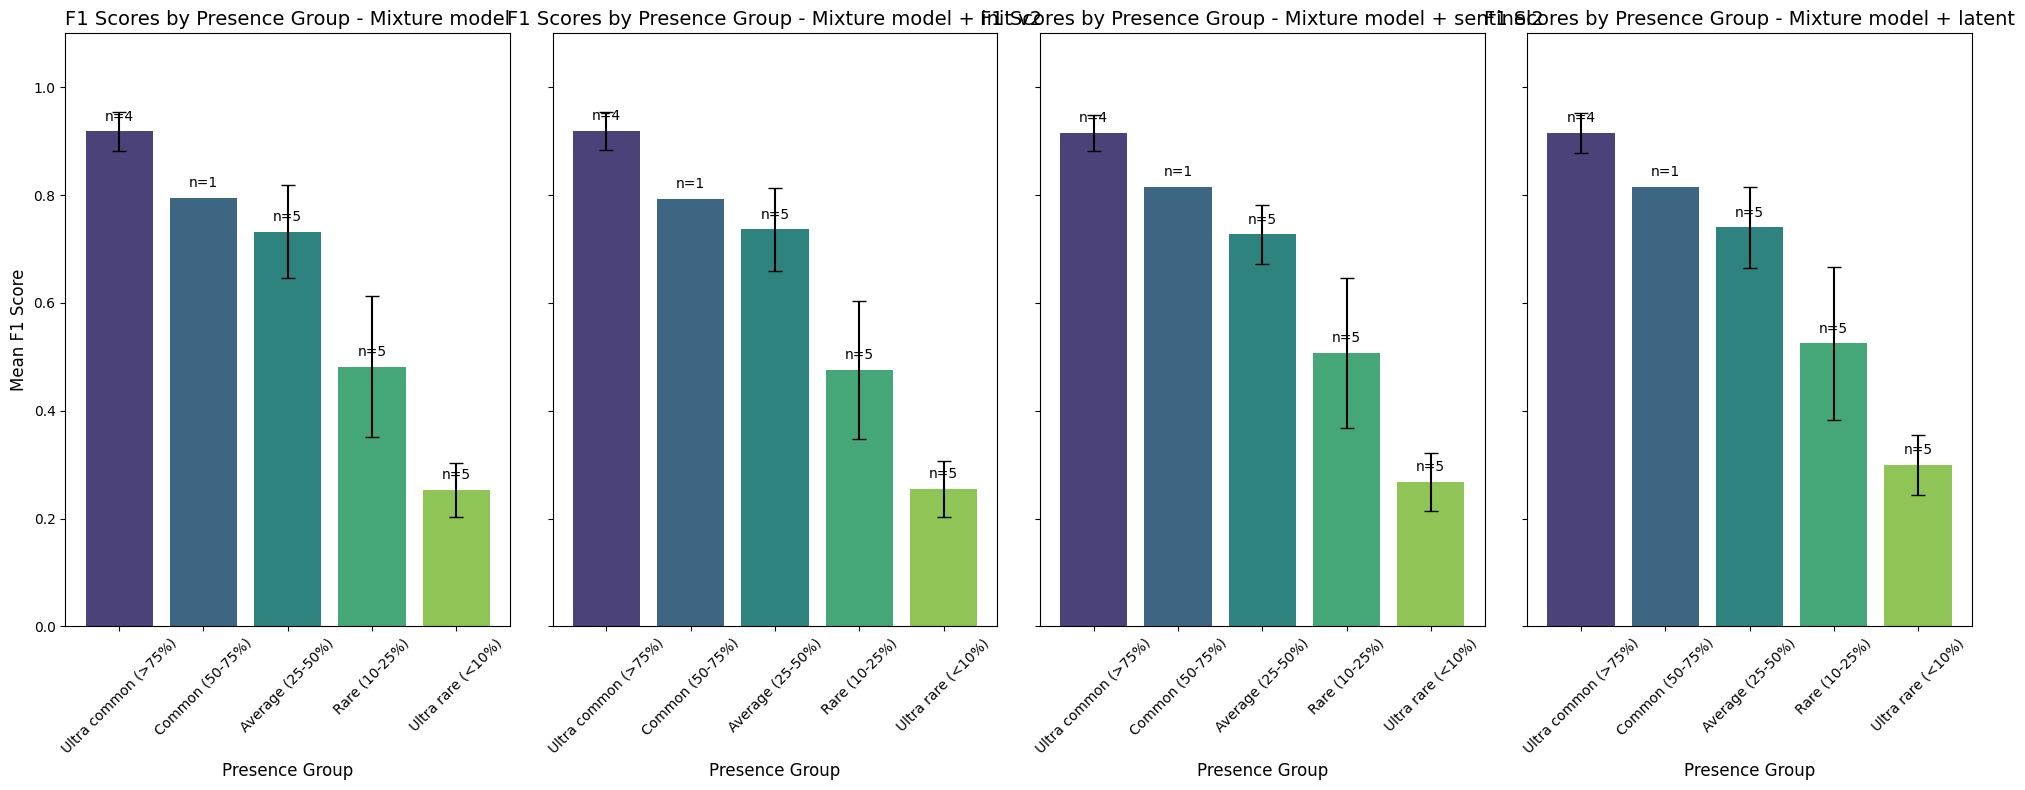

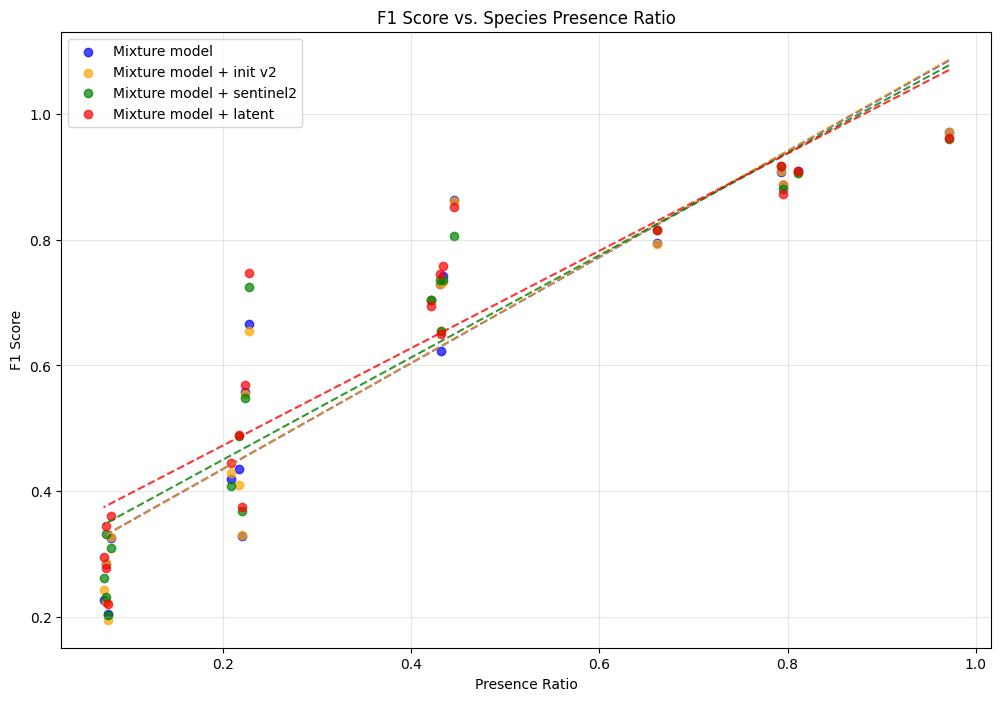

Correlation between presence ratio and F1 score (Mixture model): 0.9184
Correlation between presence ratio and F1 score (Mixture model + init v2): 0.9210
Correlation between presence ratio and F1 score (Mixture model + sentinel2): 0.9173
Correlation between presence ratio and F1 score (Mixture model + latent): 0.9072

Comparison of mean F1 scores across presence groups:
                    Mixture model Mixture model + init v2  \
Ultra common (>75%)      0.918153                0.918662   
Common (50-75%)          0.795351                0.792936   
Average (25-50%)         0.732148                0.736249   
Rare (10-25%)            0.481345                0.475746   
Ultra rare (<10%)        0.253415                 0.25539   

                    Mixture model + sentinel2 Mixture model + latent  
Ultra common (>75%)                  0.915679               0.914958  
Common (50-75%)                      0.815842               0.815013  
Average (25-50%)                     0.727024  

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create dataframes from the per-species results for each model
species_dfs = []
for i in range(len(results)):
    df = pd.DataFrame(results['final_val_metrics'][i]['per_species']).T
    # Get model name from config
    model_name = results['config'][i]['name']
    df['model'] = model_name
    # Add presence ratio
    presence_ratio_dict = {species: ratio for species, ratio in filtered_sorted_species}
    df['presence_ratio'] = df.index.map(presence_ratio_dict)
    species_dfs.append(df)

# Combine all results
combined_df = pd.concat(species_dfs)

# Define presence ratio groups
def categorize_presence(ratio):
    if ratio > 0.75:
        return "Ultra common (>75%)"
    elif ratio > 0.5:
        return "Common (50-75%)"
    elif ratio > 0.25:
        return "Average (25-50%)"
    elif ratio > 0.1:
        return "Rare (10-25%)"
    else:
        return "Ultra rare (<10%)"

# Add presence group to each dataframe
for df in species_dfs:
    df['presence_group'] = df['presence_ratio'].apply(categorize_presence)

# Plot F1 scores by presence group for each model
fig, axes = plt.subplots(1, len(species_dfs), figsize=(20, 8), sharey=True)
if len(species_dfs) == 1:
    axes = [axes]

for i, (df, ax) in enumerate(zip(species_dfs, axes)):
    model_name = df['model'].iloc[0]
    
    # Calculate mean F1 score per group
    group_stats = df.groupby('presence_group')['f1'].agg(['mean', 'std', 'count'])
    group_stats = group_stats.reindex(["Ultra common (>75%)", "Common (50-75%)", "Average (25-50%)", "Rare (10-25%)", "Ultra rare (<10%)"])
    
    # Bar plot
    sns.barplot(x=group_stats.index, y=group_stats['mean'], ax=ax, palette='viridis')
    
    # Add error bars
    for j, (group, stats) in enumerate(group_stats.iterrows()):
        if not np.isnan(stats['std']):
            ax.errorbar(j, stats['mean'], yerr=stats['std'], color='black', capsize=5)
    
    # Annotations
    for j, (group, stats) in enumerate(group_stats.iterrows()):
        if not np.isnan(stats['mean']):
            ax.text(j, stats['mean'] + 0.02, f"n={int(stats['count'])}", ha='center')
    
    ax.set_title(f"F1 Scores by Presence Group - {model_name}", fontsize=14)
    ax.set_xlabel("Presence Group", fontsize=12)
    if i == 0:
        ax.set_ylabel("Mean F1 Score", fontsize=12)
    ax.set_ylim(0, 1.1)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Plot F1 score vs presence ratio for all models
plt.figure(figsize=(12, 8))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, df in enumerate(species_dfs):
    model_name = df['model'].iloc[0]
    color = colors[i % len(colors)]
    
    # Scatter plot
    plt.scatter(df['presence_ratio'], df['f1'], alpha=0.7, label=model_name, color=color)
    
    # Add regression line
    x = df['presence_ratio']
    y = df['f1']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), color=color, linestyle='--', alpha=0.8)

plt.title('F1 Score vs. Species Presence Ratio')
plt.xlabel('Presence Ratio')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate correlation between F1 and presence ratio for each model
for i, df in enumerate(species_dfs):
    model_name = df['model'].iloc[0]
    corr = np.corrcoef(df['presence_ratio'], df['f1'])[0,1]
    print(f"Correlation between presence ratio and F1 score ({model_name}): {corr:.4f}")

# Compare performance across presence groups between models
presence_groups = ["Ultra common (>75%)", "Common (50-75%)", "Average (25-50%)", "Rare (10-25%)", "Ultra rare (<10%)"]
group_comparison = pd.DataFrame(index=presence_groups, columns=[df['model'].iloc[0] for df in species_dfs])

for df in species_dfs:
    model_name = df['model'].iloc[0]
    group_means = df.groupby('presence_group')['f1'].mean()
    for group in presence_groups:
        if group in group_means:
            group_comparison.loc[group, model_name] = group_means[group]

print("\nComparison of mean F1 scores across presence groups:")
print(group_comparison)

# Find best model for each presence group
best_models = group_comparison.idxmax(axis=1)
print("\nBest performing model for each presence group:")
for group, model in best_models.items():
    print(f"{group}: {model} (F1: {group_comparison.loc[group, model]:.4f})")


In [54]:
results

{'final_val_metrics': [{'per_species': {'species_0': {'f1': 0.8967535923363491,
     'precision': 0.9914680788467196,
     'recall': 0.8185572018460043,
     'accuracy': 0.8180965775902485},
    'species_1': {'f1': 0.8704220725899162,
     'precision': 0.9410511363636364,
     'recall': 0.8096547509929728,
     'accuracy': 0.8150492264416315},
    'species_2': {'f1': 0.8165399239543726,
     'precision': 0.8954134815844337,
     'recall': 0.750436808386721,
     'accuracy': 0.7285513361462729},
    'species_3': {'f1': 0.8966999232540291,
     'precision': 0.9462261094914156,
     'recall': 0.8521003500583431,
     'accuracy': 0.8422409751523675},
    'species_4': {'f1': 0.8353174603174603,
     'precision': 0.7970968759861154,
     'recall': 0.877387981938173,
     'accuracy': 0.7665260196905767},
    'species_5': {'f1': 0.8490743646062128,
     'precision': 0.9148073022312373,
     'recall': 0.7921545667447307,
     'accuracy': 0.887248007501172},
    'species_6': {'f1': 0.74030123231

/tmp/ipykernel_1512109/3990014131.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['presence_group','model'])[metrics]


Metrics found: ['accuracy', 'f1', 'precision', 'recall', 'pr_auc', 'specificity']


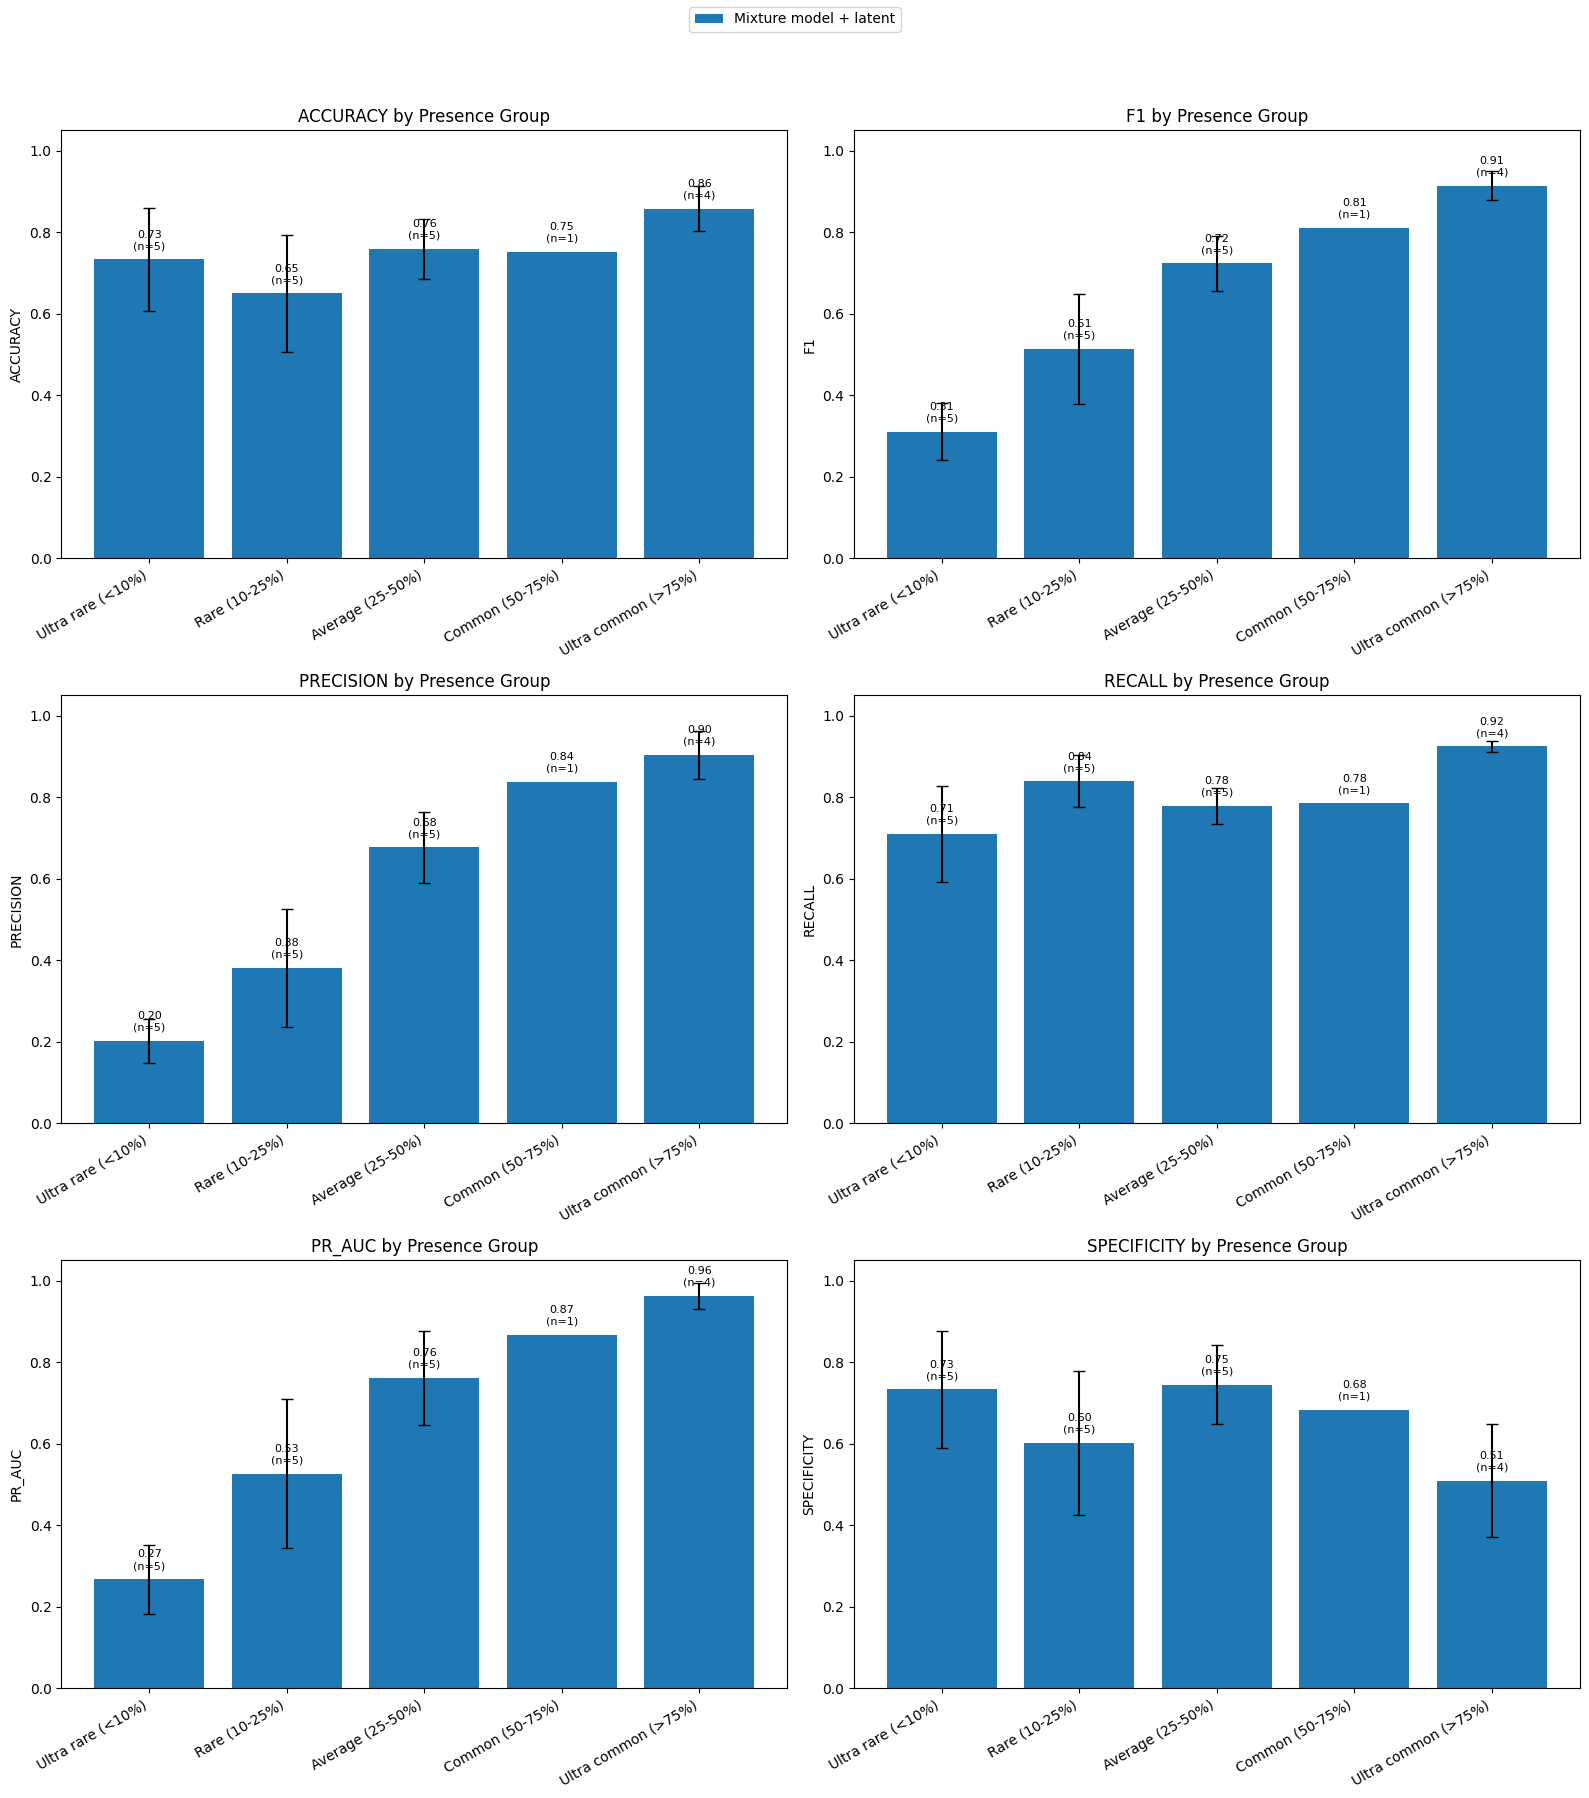

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def build_combined_df(results, filtered_sorted_species):
    """Collect all per-species metrics into a single dataframe."""
    presence_ratio_dict = dict(filtered_sorted_species)
    species_dfs = []

    n_items = len(results['final_val_metrics'])
    for i in range(n_items):
        per_species = results['final_val_metrics'][i]['per_species']
        df = pd.DataFrame(per_species).T
        df.index.name = 'species'
        df = df.reset_index()

        # Normalize columns
        df.columns = [str(c).lower() for c in df.columns]

        model_name = results['config'][i].get('name', f"model_{i}")
        df['model'] = model_name
        df['presence_ratio'] = df['species'].map(presence_ratio_dict)

        species_dfs.append(df)

    combined = pd.concat(species_dfs, ignore_index=True)
    combined = combined.dropna(subset=['presence_ratio'])
    combined['presence_ratio'] = combined['presence_ratio'].astype(float)
    return combined

def add_presence_groups(df):
    labels = [
        "Ultra rare (<10%)", "Rare (10-25%)", 
        "Average (25-50%)", "Common (50-75%)", "Ultra common (>75%)"
    ]
    bins = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]
    df['presence_group'] = pd.cut(df['presence_ratio'], bins=bins, labels=labels, include_lowest=True)
    df['presence_group'] = pd.Categorical(df['presence_group'], categories=labels, ordered=True)
    return df, labels

def summarize_metrics(df, presence_labels):
    metrics = [c for c in df.columns if c not in ['species','model','presence_ratio','presence_group']]
    agg = (df
           .groupby(['presence_group','model'])[metrics]
           .agg(['mean','std','count'])
           .reset_index())
    return agg, metrics

def plot_grouped_bars(agg, presence_labels, metrics):
    n_metrics = len(metrics)
    ncols = 2
    nrows = int(np.ceil(n_metrics / ncols))

    # Make it wide enough
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 6 * nrows), sharey=False)
    axes = axes.flatten()

    handles, labels = None, None

    for ax, metric in zip(axes, metrics):
        plot_df = pd.DataFrame({
            'presence_group': agg.reset_index()['presence_group'],
            'model': agg.reset_index()['model'],
            'mean': agg[(metric, 'mean')],
            'std': agg[(metric, 'std')],
            'count': agg[(metric, 'count')]
        })

        models = plot_df['model'].unique()
        x = np.arange(len(presence_labels))
        width = 0.8 / len(models)

        for i, model in enumerate(models):
            sub = plot_df[plot_df['model'] == model].set_index('presence_group').reindex(presence_labels)
            bars = ax.bar(x + i * width, sub['mean'], width, yerr=sub['std'],
                          capsize=4, label=model)

            for j, (m, c) in enumerate(zip(sub['mean'], sub['count'])):
                if not np.isnan(m):
                    ax.text(x[j] + i * width, m + 0.02, f"{m:.2f}\n(n={int(c)})",
                            ha='center', va='bottom', fontsize=8)

        ax.set_xticks(x + (len(models)-1) * width / 2)
        ax.set_xticklabels(presence_labels, rotation=30, ha='right')
        ax.set_ylim(0, 1.05)
        ax.set_ylabel(metric.upper())
        ax.set_title(f"{metric.upper()} by Presence Group")

        # Save legend handles once
        if handles is None:
            handles, labels = ax.get_legend_handles_labels()

    # Remove unused axes if odd number of metrics
    for ax in axes[len(metrics):]:
        ax.axis("off")

    # Shared legend outside
    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=len(handles), fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
    plt.show()


# ----------- USAGE -----------
combined = build_combined_df(results, filtered_sorted_species)
combined, presence_labels = add_presence_groups(combined)
agg, metrics = summarize_metrics(combined, presence_labels)

print("Metrics found:", metrics)

plot_grouped_bars(agg, presence_labels, metrics)


In [8]:
combined

,species,accuracy,f1,precision,recall,pr_auc,specificity,model,presence_ratio,presence_group
0,RES_S,0.929208,0.962410,0.986980,0.939033,0.996550,0.657718,Mixture model + sentinel2,0.971656,Ultra common (>75%)
1,SAB,0.852321,0.907298,0.875106,0.941949,0.968020,0.556898,Mixture model + sentinel2,0.811378,Ultra common (>75%)
2,DIS,0.792780,0.876467,0.842558,0.913221,0.921424,0.295673,Mixture model + sentinel2,0.795528,Ultra common (>75%)
3,PLS,0.869198,0.920263,0.901961,0.939323,0.969648,0.582339,Mixture model + sentinel2,0.792981,Ultra common (>75%)
4,CON,0.772855,0.829551,0.840342,0.819034,0.871777,0.677001,Mixture model + sentinel2,0.661451,Common (50-75%)
5,FEU_S,0.857243,0.824344,0.812393,0.836651,0.925330,0.870993,Mixture model + sentinel2,0.445415,Average (25-50%)
6,CLR,0.765354,0.751798,0.694457,0.819459,0.817618,0.723924,Mixture model + sentinel2,0.433527,Average (25-50%)
7,CLS,0.667370,0.668999,0.585306,0.780621,0.701084,0.581721,Mixture model + sentinel2,0.431951,Average (25-50%)
8,ERE,0.784810,0.726786,0.679844,0.780691,0.779253,0.787195,Mixture model + sentinel2,0.430535,Average (25-50%)
9,VAA,0.766995,0.712883,0.650158,0.789003,0.722061,0.754256,Mixture model + sentinel2,0.420548,Average (25-50%)


In [17]:
import pandas as pd
import numpy as np

def build_summary_table(agg, metrics, presence_labels, decimals=3):
    """
    Turn aggregated results into a dataframe:
    rows = presence groups
    columns = (metric, model)
    values = mean ± std (n)
    """
    summary = {}

    for metric in metrics:
        # Handle multi-index correctly
        sub = pd.DataFrame({
            'presence_group': agg.reset_index()['presence_group'],
            'model': agg.reset_index()['model'],
            'mean': agg[(metric, 'mean')],
            'std': agg[(metric, 'std')],
            'count': agg[(metric, 'count')]
        })

        # format values
        sub['formatted'] = sub.apply(
            lambda r: f"{r['mean']:.{decimals}f} ± {r['std']:.{decimals}f} (n={int(r['count'])})", axis=1
        )

        # pivot to wide
        wide = sub.pivot(index='presence_group', columns='model', values='formatted').reindex(presence_labels)
        summary[metric] = wide

    # concatenate along columns with metric as top-level
    summary_df = pd.concat(summary, axis=1)
    return summary_df

# ---------- USAGE ----------
combined = build_combined_df(results, filtered_sorted_species)
combined, presence_labels = add_presence_groups(combined)
agg, metrics = summarize_metrics(combined, presence_labels)

summary_df = build_summary_table(agg, metrics, presence_labels, decimals=3)

# Show nicely
import pandas.io.formats.style as style
styled_summary = (summary_df.style
                  .set_caption("Model Performance by Presence Group and Metric")
                  .set_properties(**{"text-align": "center"})
                  .set_table_styles([dict(selector="th", props=[("text-align", "center")])]))

styled_summary


/tmp/ipykernel_554928/3990014131.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['presence_group','model'])[metrics]


,precision,recall,f1,accuracy
model,simple_model,simple_model,simple_model,simple_model
presence_group,,,,
Ultra rare (<10%),0.229 ± 0.055 (n=5),0.735 ± 0.104 (n=5),0.345 ± 0.064 (n=5),0.772 ± 0.074 (n=5)
Rare (10-25%),0.437 ± 0.131 (n=5),0.756 ± 0.111 (n=5),0.550 ± 0.130 (n=5),0.739 ± 0.096 (n=5)
Average (25-50%),0.645 ± 0.126 (n=5),0.855 ± 0.041 (n=5),0.730 ± 0.077 (n=5),0.740 ± 0.092 (n=5)
Common (50-75%),0.833 ± nan (n=1),0.801 ± nan (n=1),0.817 ± nan (n=1),0.758 ± nan (n=1)
Ultra common (>75%),0.934 ± 0.045 (n=4),0.817 ± 0.069 (n=4),0.871 ± 0.059 (n=4),0.805 ± 0.076 (n=4)


In [7]:
from model_analysis import demonstrate_visualizations

demonstrate_visualizations(results)

ModuleNotFoundError: No module named 'model_analysis'

Results DataFrame shape: (3, 8)
Available columns: ['train_metrics', 'val_metrics', 'best_val_metric', 'best_epoch', 'final_val_metrics', 'stopped_early', 'epochs_completed', 'config']
SCENARIO DETAILS - Index 0
Config: Latent dim:10 kl:0.01 annealing 10 epochs
Cell Size: N/A
Species: N/A
Epochs Completed: 12
Stopped Early: True
Best Epoch: 7
Best Val Metric: 0.7693

Final Validation Metrics (Macro):
  accuracy: 0.8597
  f1: 0.7330
  precision: 0.7605
  recall: 0.7283
  pr_auc: 0.8250
  specificity: 0.7543
  loss: 0.3050

Training Positive Ratio: N/A
Validation Positive Ratio: N/A
SCENARIO DETAILS - Index 1
Config: no Latent
Cell Size: N/A
Species: N/A
Epochs Completed: 14
Stopped Early: True
Best Epoch: 9
Best Val Metric: 0.7575

Final Validation Metrics (Macro):
  accuracy: 0.8646
  f1: 0.7419
  precision: 0.7597
  recall: 0.7365
  pr_auc: 0.8279
  specificity: 0.7766
  loss: 0.2991

Training Positive Ratio: N/A
Validation Positive Ratio: N/A
SCENARIO DETAILS - Index 2
Config: Latent

/home/alexisb1/species-dist/./notebooks/model_analysis.py:60: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


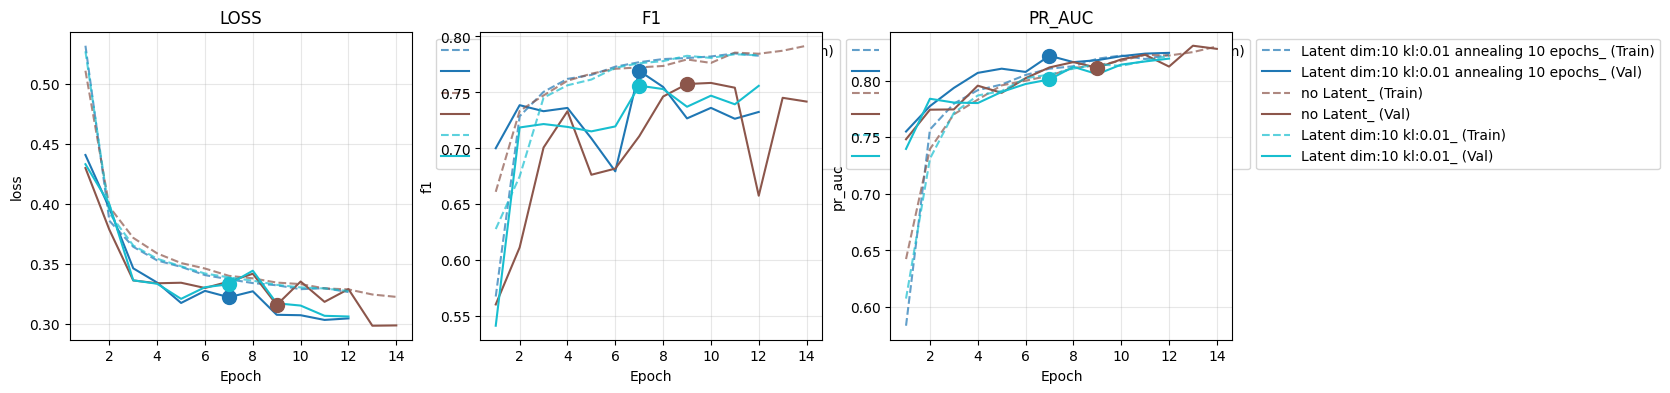

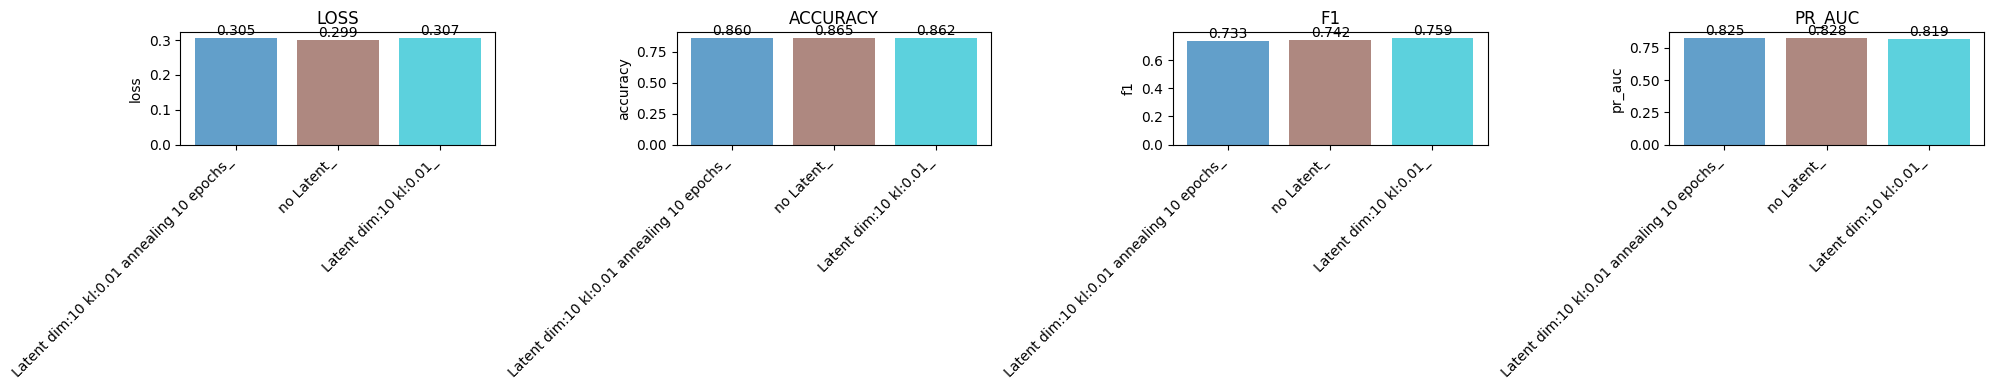


Comparison Table:
                                  Scenario                                    Config Cell_Size Species  Epochs  Stopped_Early  Best_Epoch  accuracy       f1  precision   recall   pr_auc  specificity     loss
Latent dim:10 kl:0.01 annealing 10 epochs_ Latent dim:10 kl:0.01 annealing 10 epochs       N/A     N/A      12           True           7  0.859744 0.732997   0.760539 0.728256 0.824958     0.754297 0.304963
                                no Latent_                                 no Latent       N/A     N/A      14           True           9  0.864588 0.741850   0.759749 0.736463 0.827936     0.776589 0.299093
                    Latent dim:10 kl:0.01_                     Latent dim:10 kl:0.01       N/A     N/A      12           True           7  0.861541 0.758905   0.748379 0.772552 0.819118     0.752215 0.306721


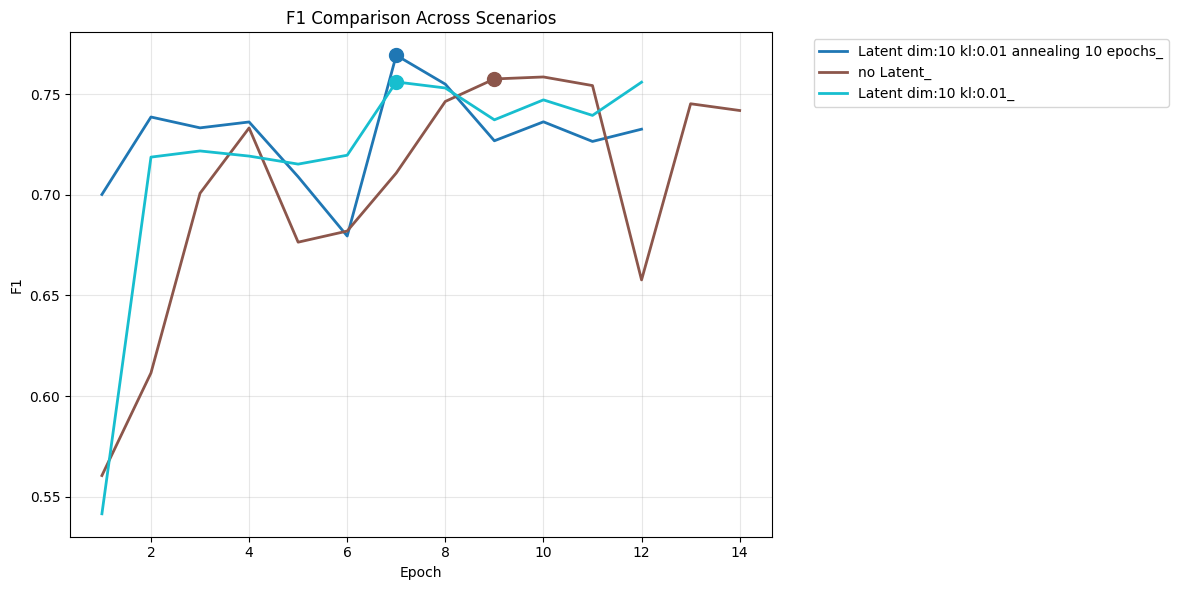

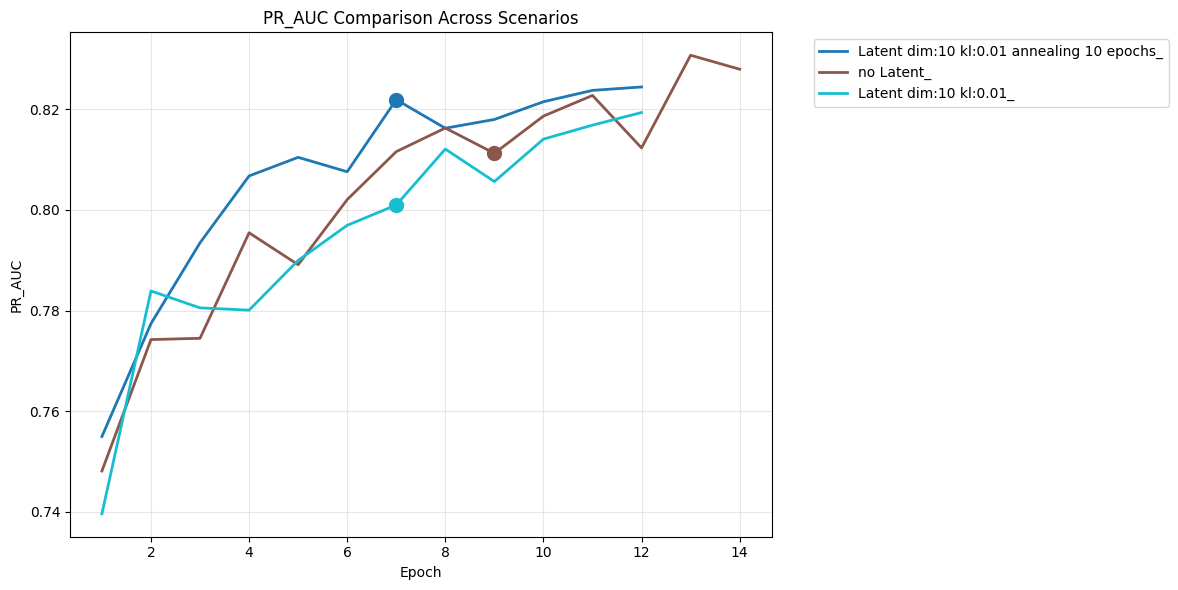

/home/alexisb1/species-dist/./notebooks/model_analysis.py:60: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


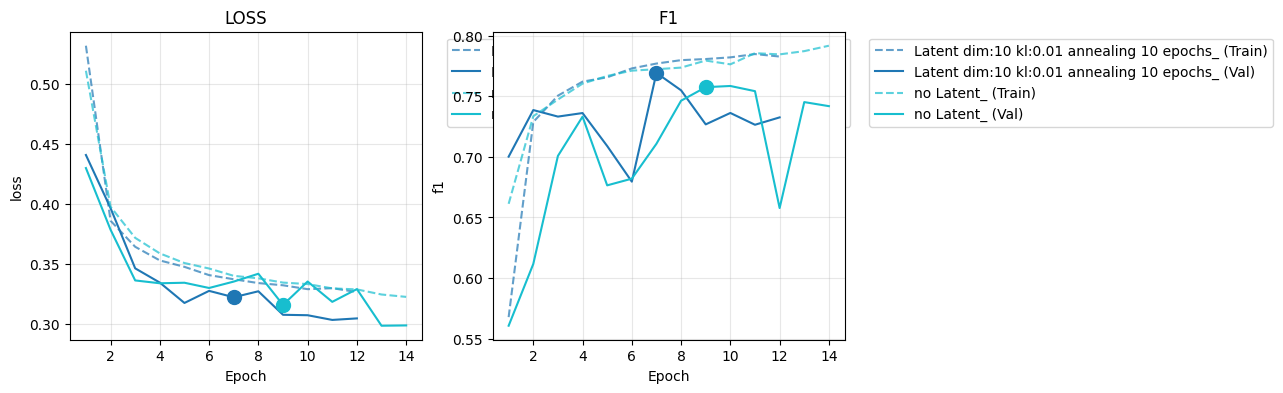

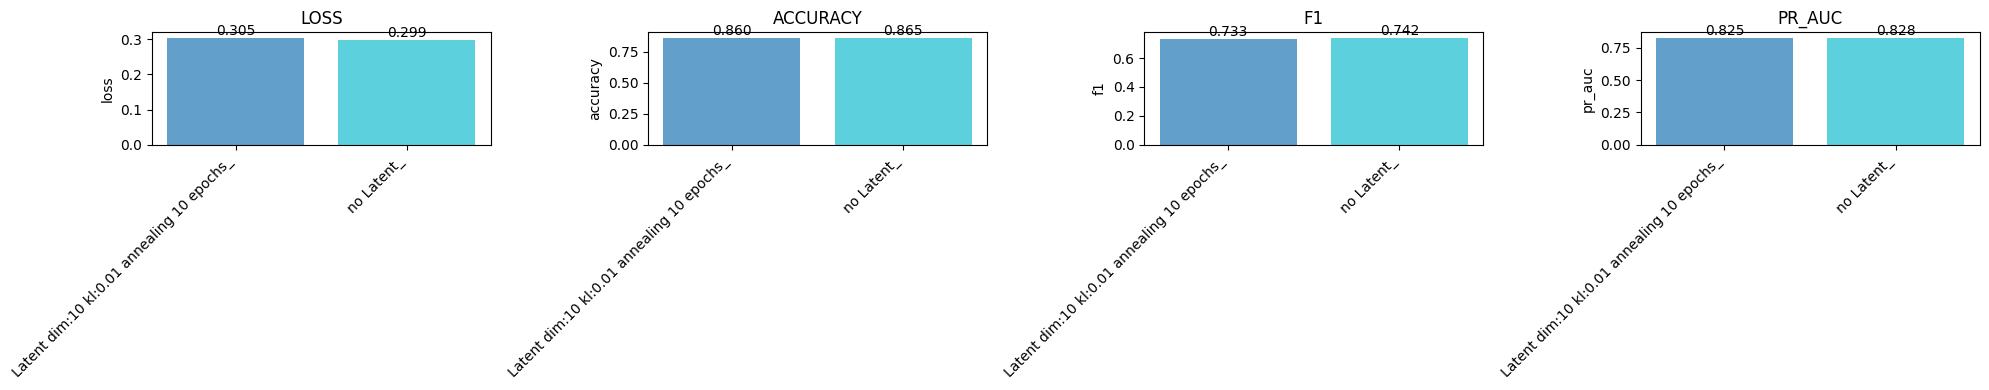

In [36]:
from model_analysis import demonstrate_visualizations

demonstrate_visualizations(results)

In [10]:
results

,train_metrics,val_metrics,best_val_metric,best_epoch,final_val_metrics,stopped_early,epochs_completed,config
0,"{'loss': [0.588994034483463, 0.493444314863108...","{'loss': [0.4985462619977839, 0.47426705851274...",0.474297,3,"{'macro': {'accuracy': 0.7762090230444662, 'f1...",True,6,"{'name': 'no Latent', 'use_attention': True, '..."
1,"{'loss': [0.5918539679503139, 0.49770365749733...","{'loss': [0.5261199404211605, 0.47356739640235...",0.474934,4,"{'macro': {'accuracy': 0.7727108803058171, 'f1...",True,7,"{'name': 'Latent dim:5 kl:0.001', 'use_attenti..."
2,"{'loss': [0.5928514577165435, 0.49530448868304...","{'loss': [0.49802863597869873, 0.4884751859833...",0.476835,7,"{'macro': {'accuracy': 0.7795989758015074, 'f1...",True,10,"{'name': 'Latent dim:10 kl:0.001', 'use_attent..."


In [52]:
pd.DataFrame.from_dict(results['final_val_metrics'])

,final_val_metrics
0,"{'macro': {'accuracy': 0.8563838099703078, 'f1..."
1,"{'macro': {'accuracy': 0.8614627285513361, 'f1..."


In [7]:
pd.DataFrame(results['final_val_metrics'][0]['per_species'])

,ERP,SAB,LEG,ARN,AUR,BOP,CHH,COG,AME,ASA,ATF,BAT,BOJ
accuracy,0.879044,0.838959,0.840366,0.695265,0.791139,0.800047,0.775668,0.562119,0.545007,0.817628,0.855368,0.851383,0.844351
f1,0.561224,0.900708,0.754240,0.720189,0.000000,0.854313,0.758028,0.515811,0.501413,0.000000,0.000000,0.000000,0.646432
precision,0.550000,0.854635,0.773501,0.609916,0.000000,0.841521,0.742079,0.497003,0.537445,0.000000,0.000000,0.000000,0.580861
recall,0.572917,0.952032,0.735915,0.879138,0.000000,0.867499,0.774677,0.536099,0.469909,0.000000,0.000000,0.000000,0.728691
pr_auc,0.595272,0.960128,0.848102,0.702751,0.390003,0.904839,0.791164,0.454348,0.490244,0.317136,0.370866,0.188354,0.646229
specificity,0.926829,0.466264,0.892481,0.547186,1.000000,0.659436,0.776491,0.582158,0.616263,1.000000,1.000000,1.000000,0.872415


In [8]:
pd.DataFrame(results['final_val_metrics'][1]['per_species'])

,ERP,SAB,LEG,ARN,AUR,BOP,CHH,COG,AME,ASA,ATF,BAT,BOJ
accuracy,0.890530,0.831692,0.822550,0.723863,0.791139,0.790670,0.775902,0.573136,0.556493,0.817628,0.855368,0.851383,0.863104
f1,0.479376,0.898559,0.743303,0.736229,0.000000,0.854726,0.772814,0.547578,0.540107,0.000000,0.000000,0.000000,0.642157
precision,0.669782,0.835742,0.716808,0.641436,0.000000,0.804841,0.715354,0.508068,0.545410,0.000000,0.000000,0.000000,0.655820
recall,0.373264,0.971586,0.771831,0.863899,0.000000,0.911204,0.840310,0.593750,0.534906,0.000000,0.000000,0.000000,0.629052
pr_auc,0.616726,0.957876,0.842480,0.705594,0.426215,0.915453,0.786838,0.472300,0.489530,0.344743,0.327853,0.189070,0.669711
specificity,0.971274,0.370594,0.847857,0.611088,1.000000,0.539407,0.722437,0.557261,0.576976,1.000000,1.000000,1.000000,0.919895


In [ ]:
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

class MultiSourceAugmentation:
    """Proper augmentation that distinguishes between data sources"""
    
    def __init__(self, npy_files, satellite_aug=None, climate_aug=None, tabular_aug=None):
        self.npy_files = npy_files  # Store the file metadata to identify sources
        self.satellite_aug = satellite_aug
        self.climate_aug = climate_aug
        self.tabular_aug = tabular_aug
        
        # Map source names to augmentation types
        self.source_to_aug = {}
        for i, npy_file in enumerate(npy_files):
            source_name = npy_file['name']
            if 'pred100' in source_name.lower() or 'sentinel' in source_name.lower() or 'landsat' in source_name.lower():
                self.source_to_aug[i] = 'satellite'
            elif 'climate' in source_name.lower() or 'weather' in source_name.lower() or 'temp' in source_name.lower():
                self.source_to_aug[i] = 'climate'
            else:
                self.source_to_aug[i] = 'climate'  # Default to climate for non-satellite
    
    def __call__(self, data_items):
        augmented_items = []
        
        for i, tensor in enumerate(data_items):
            # Handle tabular data (1D tensors)
            if tensor.dim() == 1:
                if self.tabular_aug:
                    tensor = self.tabular_aug(tensor)
                augmented_items.append(tensor)
                continue
                
            # Handle image-like data (3D tensors)
            if tensor.dim() == 3:
                source_type = self.source_to_aug.get(i, 'climate')  # Default to climate
                
                if source_type == 'satellite' and self.satellite_aug:
                    tensor = self.satellite_aug(tensor)
                elif source_type == 'climate' and self.climate_aug:
                    tensor = self.climate_aug(tensor)
                
                augmented_items.append(tensor)
                continue
            
            # For any other type, pass through unchanged
            augmented_items.append(tensor)
        
        return augmented_items
    


class SatelliteAugmentation:
    """Augmentations for normalized multispectral satellite data (0-1),
    safe from saturation while preserving variability."""
    
    def __init__(self, apply_geometric=True, apply_spectral=True):
        self.apply_geometric = apply_geometric
        self.apply_spectral = apply_spectral

    # Small safe brightness adjustment
    def adjust_brightness(self, tensor, factor):
        return tensor * factor  # no clamping here yet

    # Small safe contrast adjustment
    def adjust_contrast(self, tensor, factor):
        mean = tensor.mean(dim=(-2, -1), keepdim=True)
        return (tensor - mean) * factor + mean  # no clamping yet

    def __call__(self, tensor):
        """
        tensor: (C, H, W) normalized 0-1
        """
        # ----------- Geometric transformations -----------
        if self.apply_geometric:
            # Horizontal flip
            if torch.rand(1) > 0.5:
                tensor = torch.flip(tensor, dims=[-1])
            # Vertical flip
            if torch.rand(1) > 0.5:
                tensor = torch.flip(tensor, dims=[-2])
            # 90° rotations
            if torch.rand(1) > 0.5:
                k = torch.randint(0, 4, (1,)).item()
                tensor = torch.rot90(tensor, k, dims=[-2, -1])

        # ----------- Spectral / value-based transformations -----------
        if self.apply_spectral:
            # Safe brightness adjustment (small factor)
            if torch.rand(1) > 0.7:
                brightness_factor = 0.98 + 0.04 * torch.rand(1).item()  # 0.98–1.02
                tensor = self.adjust_brightness(tensor, brightness_factor)

            # Safe contrast adjustment
            if torch.rand(1) > 0.7:
                contrast_factor = 0.98 + 0.04 * torch.rand(1).item()  # 0.98–1.02
                tensor = self.adjust_contrast(tensor, contrast_factor)

            # Add small noise
            if torch.rand(1) > 0.7:
                noise_std = 0.01  # smaller to avoid clipping
                noise = torch.randn_like(tensor) * noise_std
                tensor = tensor + noise

            # Channel-wise small adjustments
            if torch.rand(1) > 0.9 and tensor.shape[0] > 1:  # less frequent
                channels_to_adjust = torch.randperm(tensor.shape[0])[:max(1, tensor.shape[0]//3)]
                for c in channels_to_adjust:
                    factor = 0.98 + 0.04 * torch.rand(1).item()
                    tensor[c] = tensor[c] * factor

        # ----------- Clamp only once at the end -----------
        tensor = torch.clamp(tensor, 0, 1)

        return tensor



class ClimateDataAugmentation:
    """Climate-specific augmentations that work with any number of channels"""
    
    def __init__(self, apply_spatial=True, apply_value=True):
        self.apply_spatial = apply_spatial
        self.apply_value = apply_value
    
    def __call__(self, tensor):
        # tensor shape: (C, H, W) where C are different climate variables
        
        # Spatial transformations
        if self.apply_spatial:
            if torch.rand(1) > 0.5:
                tensor = torch.flip(tensor, dims=[-1])  # Horizontal flip
            if torch.rand(1) > 0.5:
                tensor = torch.flip(tensor, dims=[-2])  # Vertical flip
            if torch.rand(1) > 0.5:
                k = torch.randint(0, 4, (1,)).item()
                tensor = torch.rot90(tensor, k, dims=[-2, -1])  # 90° rotations
        
        # Value-based transformations
        if self.apply_value:
            # Small noise proportional to each variable's range
            if torch.rand(1) > 0.7:
                # Calculate per-channel noise based on variance
                noise_levels = tensor.std(dim=(-1, -2), keepdim=True) * 0.05  # 5% of std
                noise = torch.randn_like(tensor) * noise_levels
                tensor = tensor + noise
            
            # Simple smoothing using average pooling (works with any channel count)
            if torch.rand(1) > 0.8:
                # Use average pooling for smoothing
                smoothed = F.avg_pool2d(
                    tensor.unsqueeze(0), kernel_size=3, padding=1, stride=1
                ).squeeze(0)
                alpha = 0.3
                tensor = (1 - alpha) * tensor + alpha * smoothed
        
        return tensor


class TabularAugmentation:
    """Augmentations for tabular climate data"""
    
    def __init__(self, noise_std=0.05, feature_dropout=0.1):
        self.noise_std = noise_std
        self.feature_dropout = feature_dropout
    
    def __call__(self, tensor):
        # tensor shape: (features,)
        
        # Add small Gaussian noise
        if torch.rand(1) > 0.5:
            noise = torch.randn_like(tensor) * self.noise_std
            tensor = tensor + noise
        
        # Random feature dropout
        if torch.rand(1) > 0.5:
            mask = torch.rand_like(tensor) > self.feature_dropout
            tensor = tensor * mask.float()
        
        return tensor


In [ ]:
import torch
from torch.utils.data import Sampler
import numpy as np

class TrueBalancedBatchSampler(Sampler):
    """
    True balanced batch sampler that ensures each batch has equal representation
    from each class. For multi-label data, balances based on the rarest class per sample.
    """
    
    def __init__(self, dataset, batch_size, balance_strategy="rarest_class", seed=None):
        """
        Parameters
        ----------
        dataset : Dataset
            Dataset with multi-label targets
        batch_size : int
            Must be divisible by number of classes for true balance
        balance_strategy : str
            "rarest_class" - balance by the rarest class in each sample
            "majority_class" - balance by the most frequent class in each sample  
            "explicit_groups" - use predefined presence groups
        seed : int, optional
            Random seed
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.balance_strategy = balance_strategy
        self.seed = seed
        
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        # Get targets and compute class information
        targets = self._get_targets_array()
        self.num_classes = targets.shape[1]
        self.num_samples = len(dataset)
        
        # Group samples by their rarest class (or other strategy)
        self.sample_groups = self._create_sample_groups(targets)
        
        # Calculate batches per epoch
        self._calculate_batch_parameters()
        
        print(f"Balanced sampler: {len(self.sample_groups)} groups, {self.batches_per_epoch} batches/epoch")
        for group_id, indices in self.sample_groups.items():
            print(f"  Group {group_id}: {len(indices)} samples")
    
    def _get_targets_array(self):
        """Get targets as numpy array"""
        if hasattr(self.dataset, 'targets'):
            targets = np.array(self.dataset.targets)
        else:
            # Fallback: collect targets manually
            targets = []
            for i in range(len(self.dataset)):
                item = self.dataset[i]
                if isinstance(item, (tuple, list)) and len(item) > 1:
                    target = item[1]
                else:
                    target = item
                targets.append(np.array(target))
            targets = np.vstack(targets)
        return targets
    
    def _create_sample_groups(self, targets):
        """Group samples by their class characteristics"""
        sample_groups = defaultdict(list)
        class_counts = targets.sum(axis=0)
        class_frequencies = class_counts / len(targets)
        
        for idx, sample_targets in enumerate(targets):
            present_classes = np.where(sample_targets > 0)[0]
            
            if len(present_classes) == 0:
                # No positive classes - put in separate group
                group_id = -1
            else:
                if self.balance_strategy == "rarest_class":
                    # Use the rarest class in this sample as group identifier
                    class_rarities = [class_frequencies[cls] for cls in present_classes]
                    rarest_class = present_classes[np.argmin(class_rarities)]
                    group_id = rarest_class
                
                elif self.balance_strategy == "majority_class":
                    # Use the most common class in this sample
                    class_commonness = [class_counts[cls] for cls in present_classes]
                    majority_class = present_classes[np.argmax(class_commonness)]
                    group_id = majority_class
                
                elif self.balance_strategy == "explicit_groups":
                    # Group by presence percentage (like your ultra-rare, rare, etc.)
                    presence_ratio = len(present_classes) / self.num_classes
                    if presence_ratio < 0.1:
                        group_id = 0  # Ultra rare
                    elif presence_ratio < 0.25:
                        group_id = 1  # Rare
                    elif presence_ratio < 0.5:
                        group_id = 2  # Average
                    elif presence_ratio < 0.75:
                        group_id = 3  # Common
                    else:
                        group_id = 4  # Ultra common
                else:
                    group_id = 0  # Default
            
            sample_groups[group_id].append(idx)
        
        return sample_groups
    
    def _calculate_batch_parameters(self):
        """Calculate how many samples to take from each group per batch"""
        self.groups = list(self.sample_groups.keys())
        self.num_groups = len(self.groups)
        
        # Ensure batch size is divisible by number of groups
        if self.batch_size % self.num_groups != 0:
            # Adjust to nearest divisible size
            self.batch_size = (self.batch_size // self.num_groups) * self.num_groups
            print(f"Adjusted batch size to {self.batch_size} for {self.num_groups} groups")
        
        self.samples_per_group = self.batch_size // self.num_groups
        
        # Calculate epochs based on the smallest group
        group_sizes = [len(self.sample_groups[g]) for g in self.groups]
        min_group_size = min(group_sizes)
        self.batches_per_epoch = min_group_size // self.samples_per_group
        
        # Shuffle each group
        for group_id in self.groups:
            np.random.shuffle(self.sample_groups[group_id])
        
        # Create group iterators
        self.group_iterators = {}
        for group_id in self.groups:
            self.group_iterators[group_id] = iter(self.sample_groups[group_id])
    
    def __iter__(self):
        """Generate balanced batches"""
        for batch_idx in range(self.batches_per_epoch):
            batch_indices = []
            
            for group_id in self.groups:
                for _ in range(self.samples_per_group):
                    try:
                        # Get next sample from this group
                        sample_idx = next(self.group_iterators[group_id])
                        batch_indices.append(sample_idx)
                    except StopIteration:
                        # Reset iterator for this group if exhausted
                        np.random.shuffle(self.sample_groups[group_id])
                        self.group_iterators[group_id] = iter(self.sample_groups[group_id])
                        sample_idx = next(self.group_iterators[group_id])
                        batch_indices.append(sample_idx)
            
            # Shuffle the batch to mix groups
            np.random.shuffle(batch_indices)
            yield batch_indices
    
    def __len__(self):
        return self.batches_per_epoch


In [ ]:
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
from model_evaluation import get_pred_100_band_names, compute_pos_weight, create_dataset
from model_preprocess import create_target_species_df_multiple
import pandas as pd
# Augmentation pipeline

# Create source-specific augmentations
satellite_aug = SatelliteAugmentation(apply_geometric=True, apply_spectral=True)
climate_aug = ClimateDataAugmentation(apply_spatial=True, apply_value=True) 
tabular_aug = TabularAugmentation(noise_std=0.03, feature_dropout=0.1)


target_species_arr = species_names
pred_100_band_names = get_pred_100_band_names()

        
# Create target DataFrame
target_df = create_target_species_df_multiple(target_species_arr, processed_species_original_locations)

pos_weights = compute_pos_weight(target_df)
print(f"Computed pos_weight: {pos_weights}")

# Get feature importance
pred_100_by_locations = pd.read_csv("./data/saved_df/processed_species_original_locations_point_data.csv")

pred_100_indices = range(len(pred_100_band_names))

npy_files = [
    # {
    #     "path": "../scratch/data/npy_data/sentinel2_patches.npy",
    #     'name': 'sentinel2',
    # },
    {
        "path": "../scratch/data/npy_data/pred100_patches.npy",
        'name': 'pred_100',
    },
]



training_dataset = create_dataset(
    npy_files=npy_files,
    target_df=target_df,
    processed_species_original_locations=processed_species_original_locations,
    indices=range(len(target_df)),
    pred_100_indices=pred_100_indices,
    transform=multi_aug,
    include_coords=True,
    resize_ratio=0.5,
    add_point_infos=True,
    feature_importance_only_tabular =True
)

# Enhanced sampler
sampler = AutoClassAwareBatchSampler(
    training_dataset, 
    batch_size=32,
    oversample_factor=3,
)
batch_size = 1
# DataLoader
train_loader = DataLoader(
    training_dataset, 
    batch_size=batch_size, 
    sampler=sampler,
    num_workers=4, 
    pin_memory=True, 
    drop_last=True
)

Computed pos_weight: [0.029170654571166754, 0.2324712214081664, 0.2570266836085098, 0.2610646542931567, 0.5118283513659075, 1.2450980392145559, 1.3066592053709134, 1.3150800336971682, 1.3226897069859853, 1.3778482838175388, 3.4030621328050508, 3.4820587169201125, 3.558053814958426, 3.6124580380387683, 3.7948817371000487, 11.359820089898252, 11.996321597414628, 12.239828693724627, 12.254019292538832, 12.77060133623179]
Processed species locations shape in dataset: (24732, 69)
Loading shape from: ../scratch/data/npy_data/pred100_patches.npy
Loaded with shape: [24732, 67, 100, 100]
Extracted point infos shape: (24732, 67)
Extracted coordinates shape: torch.Size([24732, 2])
Dataset size: 24732, Positives: 189729.0, Positive ratio: 7.6714


In [67]:
batch_size = 256


# balanced_dataloader = DataLoader(
#     training_dataset,
#     batch_sampler=SpeciesBalancedBatchSampler(
#         dataset=training_dataset,
#         species_configs=species_configs,
#         batch_size=batch_size,
#         num_batches=200,
#         alpha= 3
#     ),
#     num_workers=2,
#     pin_memory=True
# )

base_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, 
                            num_workers=2, pin_memory=True, drop_last=True)

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def show_single_batch(dataloader, species_names):
    """Show what one batch looks like - fixed version"""
    # Get batch with proper error handling
    try:
        batch = next(iter(dataloader))
    except TypeError as e:
        print(f"Indexing error: {e}")
        print("Your sampler might be returning non-integer indices")
        return
    
    # Extract targets - adjust based on your dataset structure
    if isinstance(batch, (list, tuple)):
        # Usually batch is (features, targets) or (features, targets, coords)
        if len(batch) >= 2:
            targets = batch[1]
        else:
            targets = batch[0]  # Fallback
    else:
        targets = batch
    
    # Ensure targets are in the right format
    if hasattr(targets, 'numpy'):
        targets = targets.numpy()
    
    print(f"Targets shape: {targets.shape}")
    print(f"Targets type: {type(targets)}")
    
    # Calculate presence ratios
    presence_ratios = targets.sum(axis=0) / targets.shape[0]
    
    # Plot
    plt.figure(figsize=(12, 4))
    bars = plt.bar(range(len(species_names)), presence_ratios)
    plt.xticks(range(len(species_names)), species_names, rotation=45, ha='right')
    plt.ylabel('Presence Ratio')
    plt.title(f'Species Presence in One Batch (Size: {targets.shape[0]})')
    plt.grid(True, alpha=0.3)
    
    # Color bars by prevalence level
    for i, ratio in enumerate(presence_ratios):
        if ratio > 0.5:
            bars[i].set_color('red')    # Very common in this batch
        elif ratio > 0.1:
            bars[i].set_color('orange') # Medium presence
        elif ratio > 0:
            bars[i].set_color('green')  # Rare but present
        else:
            bars[i].set_color('gray')   # Not present
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    present_species = presence_ratios > 0
    print(f"Species with samples: {present_species.sum()}/{len(species_names)}")
    print(f"Average presence: {presence_ratios.mean():.3f}")
    
    # Show top 5 most present species
    top_indices = np.argsort(presence_ratios)[::-1]
    for idx in top_indices:
        if presence_ratios[idx] > 0:
            print(f"  {species_names[idx]}: {presence_ratios[idx]:.1%}")

def debug_sampler_indices(dataloader):
    """Debug what indices your sampler is returning"""
    print("Debugging sampler indices...")
    
    try:
        # Get the sampler from dataloader
        sampler = dataloader.sampler
        print(f"Sampler type: {type(sampler)}")
        
        # Get one batch of indices
        indices = next(iter(sampler))
        print(f"Indices type: {type(indices)}")
        print(f"Indices shape: {getattr(indices, 'shape', 'No shape')}")
        print(f"First few indices: {indices[:5] if hasattr(indices, '__getitem__') else indices}")
        print(f"Indices dtype: {getattr(indices, 'dtype', 'No dtype')}")
        
    except Exception as e:
        print(f"Error debugging sampler: {e}")

# Test with your dataloader
def test_dataloader(dataloader, species_names):
    """Test if dataloader works and show batch"""
    print("Testing dataloader...")
    
    # First debug the sampler
    debug_sampler_indices(dataloader)
    
    # Then try to show a batch
    show_single_batch(dataloader, species_names)

Targets shape: (256, 20)
Targets type: <class 'numpy.ndarray'>


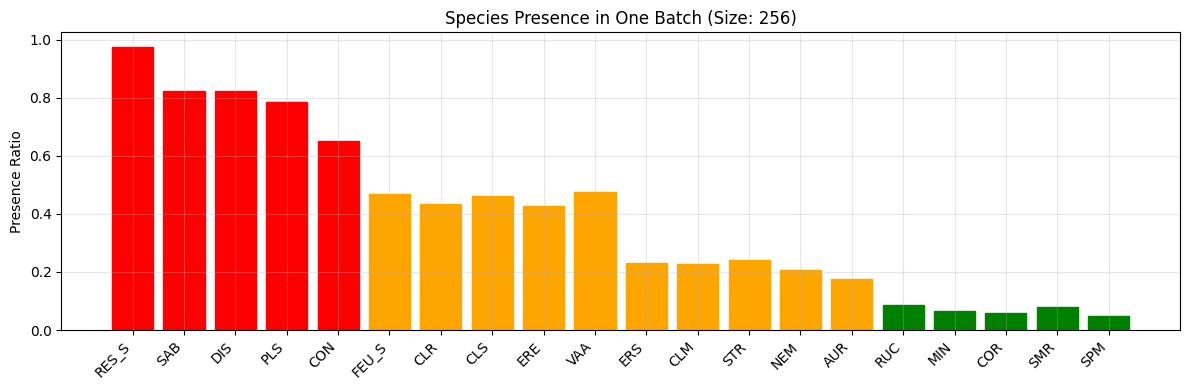

Species with samples: 20/20
Average presence: 0.387
  RES_S: 97.7%
  DIS: 82.4%
  SAB: 82.4%
  PLS: 78.5%
  CON: 65.2%
  VAA: 47.7%
  FEU_S: 46.9%
  CLS: 46.1%
  CLR: 43.4%
  ERE: 42.6%
  STR: 24.2%
  ERS: 23.0%
  CLM: 22.7%
  NEM: 20.7%
  AUR: 17.6%
  RUC: 8.6%
  SMR: 7.8%
  MIN: 6.6%
  COR: 5.9%
  SPM: 4.7%


In [68]:

show_single_batch(base_dataloader, species_names)

Targets shape: (256, 20)
Targets type: <class 'numpy.ndarray'>


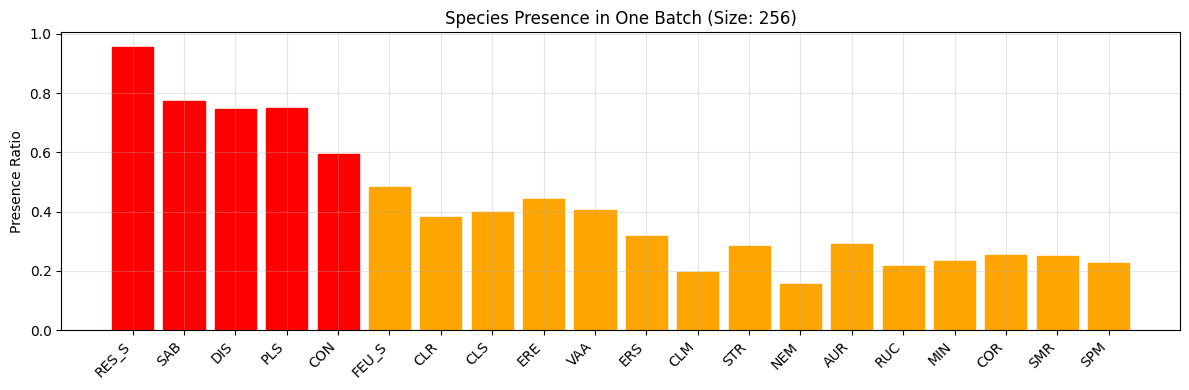

Species with samples: 20/20
Average presence: 0.418
  RES_S: 95.7%
  SAB: 77.3%
  PLS: 75.0%
  DIS: 74.6%
  CON: 59.4%
  FEU_S: 48.4%
  ERE: 44.1%
  VAA: 40.6%
  CLS: 39.8%
  CLR: 38.3%
  ERS: 31.6%
  AUR: 28.9%
  STR: 28.5%
  COR: 25.4%
  SMR: 25.0%
  MIN: 23.4%
  SPM: 22.7%
  RUC: 21.5%
  CLM: 19.5%
  NEM: 15.6%


In [71]:
# Quick look at one batch
# Enhanced sampler
batch_size = 256
sampler = AutoClassAwareBatchSampler(
    training_dataset, 
    batch_size=batch_size,
    oversample_factor=3,
)

# DataLoader
train_loader = DataLoader(
    training_dataset, 
    batch_size=batch_size, 
    sampler=sampler,
    num_workers=4, 
    pin_memory=True, 
    drop_last=True
)
show_single_batch(train_loader, species_names)

In [28]:
test_dataloader(balanced_dataloader, species_names)


Testing dataloader...
Debugging sampler indices...
Sampler type: <class '__main__.AdaptiveBalancedSampler'>
Indices type: <class 'list'>
Indices shape: No shape
First few indices: [984, 22, 141, 20, 567]
Indices dtype: No dtype
Indexing error: range indices must be integers or slices, not list
Your sampler might be returning non-integer indices



Satellite (first 3 channels)
Channel 0: min=0.000, max=0.097, mean=0.023, normalized=True
Channel 1: min=0.000, max=0.099, mean=0.040, normalized=True
Channel 2: min=0.000, max=0.072, mean=0.024, normalized=True


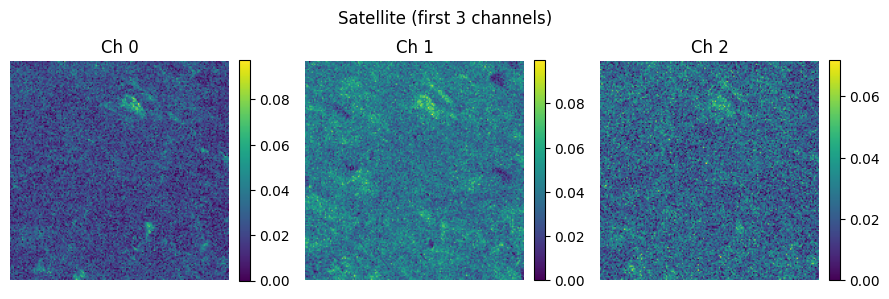


Climate (first 10 channels)
Channel 0: min=0.000, max=0.000, mean=0.000, normalized=True
Channel 1: min=0.359, max=0.462, mean=0.435, normalized=True
Channel 2: min=0.712, max=0.867, mean=0.854, normalized=True
Channel 3: min=0.000, max=0.000, mean=0.000, normalized=True
Channel 4: min=0.592, max=0.804, mean=0.774, normalized=True
Channel 5: min=0.317, max=0.474, mean=0.410, normalized=True
Channel 6: min=0.833, max=1.000, mean=0.992, normalized=True
Channel 7: min=0.000, max=1.000, mean=0.527, normalized=True
Channel 8: min=0.000, max=0.000, mean=0.000, normalized=True
Channel 9: min=0.000, max=0.764, mean=0.044, normalized=True


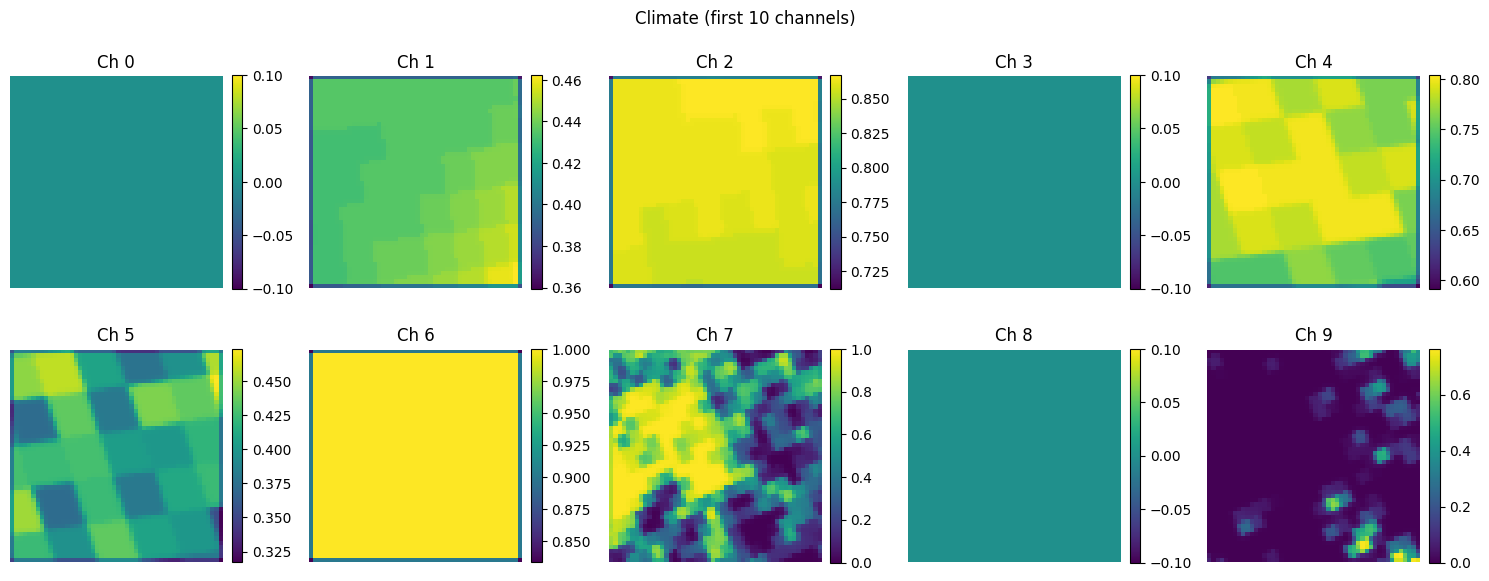

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_channels(tensor, num_channels=10, title="", cmap="viridis"):
    """
    Show first num_channels of a [C,H,W] tensor as separate heatmaps.
    Also prints min, max, mean per channel to check normalization.
    """
    if torch.is_tensor(tensor):
        arr = tensor.cpu().numpy()
    else:
        arr = np.array(tensor)

    C, H, W = arr.shape
    num_channels = min(num_channels, C)

    print(f"\n{title}")
    for i in range(num_channels):
        ch = arr[i]
        ch_min, ch_max, ch_mean = ch.min(), ch.max(), ch.mean()
        normalized_flag = (ch_min >= 0.0 and ch_max <= 1.0)
        print(f"Channel {i}: min={ch_min:.3f}, max={ch_max:.3f}, mean={ch_mean:.3f}, normalized={normalized_flag}")

    # grid size
    ncols = min(5, num_channels)
    nrows = int(np.ceil(num_channels / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    axes = axes.ravel()

    for i in range(num_channels):
        ch = arr[i]
        ax = axes[i]
        im = ax.imshow(ch, cmap=cmap)
        ax.set_title(f"Ch {i}")
        ax.axis("off")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # hide extra axes
    for j in range(num_channels, len(axes)):
        axes[j].axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example usage
data_items, targets, _ = training_dataset[0]

# say index 0 = satellite, index 1 = climate
satellite = data_items[0]
climate   = data_items[1]

show_channels(satellite, num_channels=3, title="Satellite (first 3 channels)")
show_channels(climate, num_channels=10, title="Climate (first 10 channels)")
